# Overall Useful Functions
- ```get_length(embedding_1d)```
- ```normalise_embedding(embedding_1d)```
- ```get_normalise_embedding(embedding_1d)```
- ```cosine_sim(embedding_1, embedding_2)```
- ```norm_ed_cosine_sim(embedding_1, embedding_2)```
- ```generic_sent_cos_sim(model_emb_func, t1, t2, additional_nesting = False)```

In [2]:
## Overall Useful Functions

import torch
import math
import numpy as np
def get_length(embedding_1d):
    sum = 0
    for i in embedding_1d:
        sum+=(i**2)
    return math.sqrt(sum)
def normalise_embedding(embedding_1d):
    length = get_length(embedding_1d)
    for i in range(len(embedding_1d)):
        embedding_1d[i] /= length
def get_normalise_embedding(embedding_1d):
    if type(embedding_1d) is torch.Tensor:
        temp_embedding_1d = (embedding_1d.detach().numpy()).copy()
    else:
        temp_embedding_1d = embedding_1d.copy()
    length = get_length(temp_embedding_1d)
    for i in range(len(temp_embedding_1d)):
        temp_embedding_1d[i] /= length
    return temp_embedding_1d


def cosine_sim(embedding_1, embedding_2):
    embedding_1 = get_normalise_embedding(embedding_1)
    embedding_2 = get_normalise_embedding(embedding_2)
    sim_sum = 0
    for e_1, e_2 in zip(embedding_1, embedding_2):
        sim_sum += (e_1*e_2)
    return sim_sum
def norm_ed_cosine_sim(embedding_1, embedding_2):
    sim_sum = 0
    for e_1, e_2 in zip(embedding_1, embedding_2):
        sim_sum += (e_1*e_2)
    return sim_sum

In [3]:
## Cosine Similarity -- Embedding Model

def generic_sent_cos_sim(model_emb_func, t1, t2, additional_nesting = False):
    if additional_nesting:
        return cosine_sim(model_emb_func(t1)[0], model_emb_func(t2)[0])    
    return cosine_sim(model_emb_func(t1), model_emb_func(t2))

In [124]:
### NOT USED! REPLACED!!
## emb model, similarity level

def test_emb_model(model_emb_func, sent_pair_comparison_list, sorting = False, additional_nesting = False):
    ending_dict = {}
    for comp1, comp2 in sent_pair_comparison_list:
        ending_dict[(comp1, comp2)] = generic_sent_cos_sim(model_emb_func, comp1, comp2, additional_nesting)
    if sorting:
        sorted_ending_dict = {comps:comps_res for comps, comps_res in (sorted(ending_dict.items(), key=lambda dict_item: dict_item[1], reverse = True))}
        return sorted_ending_dict
    return ending_dict
def test_emb_model_results(ending_dict, sorting = False):
    print("Similarity level:")
    #res_sum = 0
    if sorting:
        for comps, res in (sorted(ending_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
            ## print(f"{comps[0]:20.5}-{comps[1]:5.20}: {res:.5}") # "{:min_pad.max_pad}", max pad is essentially also the max number of chars permitted!!
            print(f"{comps[0]:20.20} /-/ {comps[1]:20.20} : {res:.5}")
            #res_sum += res
    else:
        for comps, res in ending_dict.items():
            ## print(f"{comps[0]:20.5}-{comps[1]:5.20}: {res:.5}") # "{:min_pad.max_pad}", max pad is essentially also the max number of chars permitted!!
            print(f"{comps[0]:20.20} /-/ {comps[1]:20.20} : {res:.5}")
            #res_sum += res
        
    ## res_sum no purpose and stuff yet since no measure of accuracy present, like it should/should not match, dont know so cannot say the sum is good or not, etc or avg, but later on can try with these and maybe weighted based on certain comparisons more impt?

In [126]:
## Embedding Model's Function / Model's Embedding Function
# Returns a 1d tensor with the embedding
# if list of input string, then 2d tensor, each 1d tensor inside the 2d tensor correspond to each input string in list

def embedding_model_function(text): ## single string or a list of strings
    return torch.tensor([1, 2, 3, 4, 5, 6]) ## eg

## EXAMPLE ABOVE (ONLY AN EXAMPLE)
### Format of this function is important!

# Semantic Segmentation Function Section

In [4]:
## Semantic Segmentation Function PREPARATION FUNCTIONS

from itertools import islice

def window(seq, n=3):
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
        
        
        
def climb(co_score_list, list_index, mode = "l"):
    res_score = 0
    if mode == "l":
        while (list_index >= 0):
            if co_score_list[list_index] > res_score:
                res_score = co_score_list[list_index]
                list_index -= 1
            else:
                break
        return res_score
    else:
        list_len = len(co_score_list)
        while (list_index < list_len):
            if co_score_list[list_index] > res_score:
                res_score = co_score_list[list_index]
                list_index += 1
            else:
                break
        return res_score
    
def get_depth_score_list(co_score_list):
    res_depth_score_list = []
    co_score_len = len(co_score_list)
    for i in range(co_score_len):
        i_co_score = co_score_list[i]
        l_peak = climb(co_score_list, i, "l")
        r_peak = climb(co_score_list, i, "r")
        i_depth_score = 0.5 * (l_peak + r_peak - (2*i_co_score))
        res_depth_score_list.append(i_depth_score)
    return np.array(res_depth_score_list)




import matplotlib.pyplot as plt

from scipy.signal import argrelmax

def get_local_maxima(depth_scores, order=1):
    maxima_ids = argrelmax(depth_scores, order=order)[0]
    filtered_scores = np.zeros(len(depth_scores))
    filtered_scores[maxima_ids] = depth_scores[maxima_ids]
    return filtered_scores

def compute_threshold(scores): ## maybe can make this more picky, by making threshold higher, like (np.std(s) / 3) or /4 or more instead?
    s = scores[np.nonzero(scores)]
    threshold = np.mean(s) - (np.std(s) / 2)
    # threshold = np.mean(s) - (np.std(s))
    return threshold

def get_threshold_segments(scores, threshold=0.1):
    segment_ids = np.where(scores >= threshold)[0]
    return segment_ids




def primitively_naive_tokeniser(text):
    toks_list = text.split(" ")
    return toks_list

In [5]:
## Semantic Segmentation Function Portions

WINDOW_SIZE = 3

def sentence_to_sliding_window(sentence_s):
    sentence_words_toks = primitively_naive_tokeniser(sentence_s)
    window_size_split = list(window(sentence_words_toks, WINDOW_SIZE))
    window_splited_texts = [' '.join([window_toks for window_toks in each_window]) for each_window in window_size_split]
    return window_splited_texts

def coherence_score_list_from_embedding_list(window_splited_embedding_list):
    coherence_scores_list = [cosine_sim(pair[0], pair[1]) for pair in zip(window_splited_embedding_list[:-1], window_splited_embedding_list[1:])]
    return coherence_scores_list

def plot_data_points(vary_data, thres = -1):
    plt.plot(vary_data)
    if (thres == -1):
        plt.show()
    else:
        plt.plot([thres for i in range(len(vary_data))])
        plt.show()

def filtered_indexes_list_to_splitted_segments_by_semantics(original_sent, filtered_indexes_list):
    sentence_words_toks = primitively_naive_tokeniser(original_sent)
    segment_key_breaks = get_threshold_segments(filtered_indexes_list, compute_threshold(filtered_indexes_list))
    segment_demark = [0] + [(ids + (WINDOW_SIZE-1)) for ids in segment_key_breaks] + [len(sentence_words_toks)]
    segment_demark_intervals = list(zip(segment_demark[:-1], segment_demark[1:]))
    resultant_segments_after_split_by_interval = [" ".join(sentence_words_toks[interval_points[0]:interval_points[1]]) for interval_points in segment_demark_intervals]
    return resultant_segments_after_split_by_interval

In [6]:
## Semantic Segmentation Function

def semantic_segmentation_function(embedding_model_function, sentence_text, intermediate_status = False, graph_status = False):
    windowed_parts = sentence_to_sliding_window(sentence_text)
    if intermediate_status:
        print(f"windowed_parts: {windowed_parts}")
    
    # if ensure "embedding_model_function" accept only 1 string and return 1d array/tensor then can use the below code, current should still work!!, as long as return 1d array for single string!!
    # embedding_list = [embedding_model_function(windowed_part) for windowed_part in windowed_parts]
    
    ## if list of input strings can produce 2d array/tensor automatically, then can just use below one!!, only 1 time embed bunch at once!!
    embedding_list = embedding_model_function(windowed_parts)
    if intermediate_status:
        print(f"embedding_list: {embedding_list}")
    """
    if graph_status:
        print("Embedding List Plot") # bad! like no use
        plot_data_points(embedding_list) # bad! like no use
    """
    
    windowed_parts_coherence_score_list = coherence_score_list_from_embedding_list(embedding_list)
    if intermediate_status:
        print(f"windowed_parts_coherence_score_list: {windowed_parts_coherence_score_list}")
    if graph_status:
        print("Coherence Score Plot:")
        plot_data_points(windowed_parts_coherence_score_list)
    
    windowed_parts_depth_score_list = get_depth_score_list(windowed_parts_coherence_score_list)
    if intermediate_status:
        print(f"windowed_parts_depth_score_list: {windowed_parts_depth_score_list}")
    if graph_status:
        print("Depth Score Plot:")
        plot_data_points(windowed_parts_depth_score_list)
    
    windowed_parts_filtered_depth_score_list = get_local_maxima(windowed_parts_depth_score_list)
    if intermediate_status:
        print(f"windowed_parts_filtered_depth_score_list: {windowed_parts_filtered_depth_score_list}")
    if graph_status:
        print("Filtered Depth Score Plot:")
        plot_data_points(windowed_parts_filtered_depth_score_list)
    
    filtered_threshold = compute_threshold(windowed_parts_filtered_depth_score_list)
    if intermediate_status:
        print(f"filtered_threshold: {filtered_threshold}")
    if graph_status:
        print("Filtered Depth Score With Threshold Line Plot:")
        plot_data_points(windowed_parts_filtered_depth_score_list, filtered_threshold)

    #sentences_tokenised = primitively_naive_tokeniser(sentences)
    #sentences_topics_splitted = filtered_indexes_list_to_splitted_sent(sentences_tokenised, windowed_sentences_filtered_depth_score_v1_list)
    sentences_topics_splitted = filtered_indexes_list_to_splitted_segments_by_semantics(sentence_text, windowed_parts_filtered_depth_score_list)
    return sentences_topics_splitted

In [52]:
# Eg.

from sentence_transformers import SentenceTransformer

model_MiniLM_L6_v2 = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

#sentences = ["This is an example sentence", "Each sentence is converted"]
#embeddings = model.encode(sentences)
def get_sentence_embedding_MiniLM_L6_v2(sentence):
    return model_MiniLM_L6_v2.encode(sentence)

c:\Users\Audric Ho\Downloads\LLM related stuff\semantic_text_segmentation_attempt\semantic_seg-venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


windowed_parts: ['Employees receive free', 'receive free flight', 'free flight benefits', 'flight benefits to', 'benefits to return', 'to return to', 'return to home', 'to home country', 'home country once', 'country once a', 'once a year', 'a year and', 'year and free', 'and free flight', 'free flight benefits', 'flight benefits for', 'benefits for business', 'for business trips']
embedding_list: [[-0.04448811  0.04795947  0.06037302 ... -0.0636269   0.05817426
  -0.03921315]
 [ 0.05608535  0.02959418 -0.01245745 ... -0.01910884 -0.06298571
  -0.07182703]
 [ 0.04054752  0.05044231  0.00771492 ... -0.04466909 -0.07142843
  -0.0505781 ]
 ...
 [ 0.04129141  0.0615066  -0.01136441 ... -0.01247263 -0.08400208
  -0.02540924]
 [-0.01858481  0.13829541  0.02429479 ... -0.05965253  0.01516818
  -0.01185296]
 [ 0.04681492  0.0108937   0.03474697 ... -0.00696682 -0.01107509
  -0.03220905]]
windowed_parts_coherence_score_list: [0.4994730746903999, 0.8198922032960355, 0.8492839794926114, 0.4910717

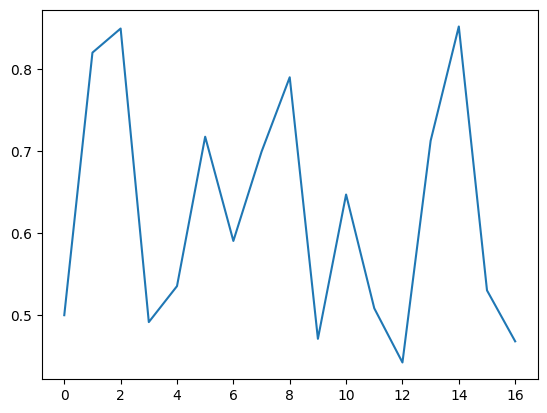

windowed_parts_depth_score_list: [0.17490545 0.01469589 0.         0.29220114 0.09115656 0.
 0.16343534 0.04542998 0.         0.24758731 0.         0.06940543
 0.30746536 0.06974462 0.         0.16100151 0.19209682]
Depth Score Plot:


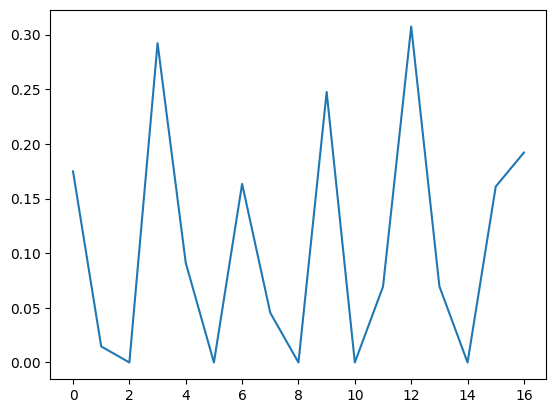

windowed_parts_filtered_depth_score_list: [0.         0.         0.         0.29220114 0.         0.
 0.16343534 0.         0.         0.24758731 0.         0.
 0.30746536 0.         0.         0.         0.        ]
Filtered Depth Score Plot:


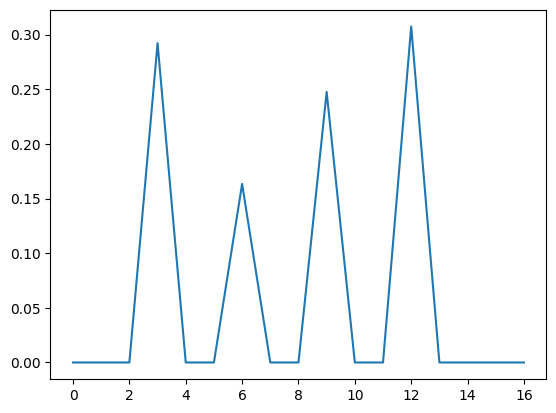

filtered_threshold: 0.22466123834278376
Filtered Depth Score With Threshold Line Plot:


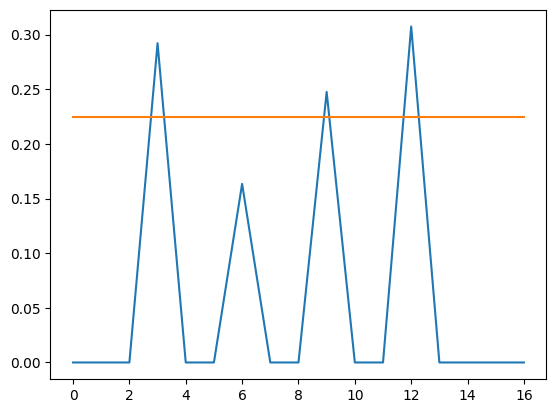

['Employees receive free flight benefits',
 'to return to home country once',
 'a year and',
 'free flight benefits for business trips']

In [73]:
# Eg. "get_sentence_embedding_MiniLM_L6_v2" embedding and statuses = True
semantic_segmentation_function(get_sentence_embedding_MiniLM_L6_v2, "Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips", intermediate_status=True, graph_status=True)

In [74]:
# Eg. "get_sentence_embedding_MiniLM_L6_v2" embedding and statuses = False
semantic_segmentation_function(get_sentence_embedding_MiniLM_L6_v2, "Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips", intermediate_status=False, graph_status=False)

['Employees receive free flight benefits',
 'to return to home country once',
 'a year and',
 'free flight benefits for business trips']

In [123]:
# Lock Model
def lock_semantic_segmentation_function(embedding_model_function):
    def lockED_semantic_segmentation_function(sentence_text, intermediate_status = False, graph_status = False): # all these default params need to have because the locked function can have the option to leave the args blank for them to let it be default!
        return semantic_segmentation_function(embedding_model_function=embedding_model_function, sentence_text=sentence_text, intermediate_status=intermediate_status, graph_status=graph_status)
    return lockED_semantic_segmentation_function

In [88]:
# Locked Model
semantic_segmentation_locked_model_MiniLM_L6_v2 = lock_semantic_segmentation_function(get_sentence_embedding_MiniLM_L6_v2)
semantic_segmentation_locked_model_MiniLM_L6_v2("Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips", intermediate_status=False, graph_status=False)

['Employees receive free flight benefits',
 'to return to home country once',
 'a year and',
 'free flight benefits for business trips']

# Similarity Comparison Function Section

In [7]:
# Generic Similarity Comparison Function (comparison tuples in a list for comparison!)

def generic_similarity_comparison_function(embedding_model_function, comparison_tuple_in_list, sort_output = 0):
    res_dict = {}
    for comp_items in comparison_tuple_in_list:
        # possible alternative is below, so that if embedding model only accept one string and return 1d array/tensor then works!!
        # comp_emb = [embedding_model_function(comp_items[0]), embedding_model_function(comp_items[1])]
        comp_emb = embedding_model_function([comp_items[0], comp_items[1]]) # or just list(comp_items)
        cos_sim = cosine_sim(comp_emb[0], comp_emb[1])
        res_dict[comp_items] = cos_sim
        
    # sort by -1 is descending, 0 is no sort, 1 is ascending!
    # default is no sort, 0
    if sort_output == -1:
        res_dict = {comp:comp_score for comp, comp_score in sorted(res_dict.items(), key = lambda dict_item: dict_item[1], reverse=True)}
    if sort_output == 1:
        res_dict = dict(sorted(res_dict.items(), key = lambda dict_item: dict_item[1], reverse=False))
    return res_dict
        

In [8]:
# Sort -1, descending
generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, [("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")], sort_output=-1)

{('i like people', 'people love me'): 0.6048486815689496,
 ('the world is green', 'the ocean is blue'): 0.4271523653033571,
 ('hi there', 'the world is bad'): 0.1287177563239086}

In [43]:
# Sort 0, no sort
generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, [("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")], sort_output=0)

{('hi there', 'the world is bad'): 0.1287177563239086,
 ('i like people', 'people love me'): 0.6048486815689496,
 ('the world is green', 'the ocean is blue'): 0.4271523653033571}

In [44]:
# Sort 1, ascending
generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, [("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")], sort_output=1)

{('hi there', 'the world is bad'): 0.1287177563239086,
 ('the world is green', 'the ocean is blue'): 0.4271523653033571,
 ('i like people', 'people love me'): 0.6048486815689496}

In [12]:
# partial does not allow arguments to be filled with keywords, need strictly positional so prefer not

## Error is like:
# generic_similarity_comparison_locked_model_MiniLM_L6_v2 = lock_generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2)
# generic_similarity_comparison_locked_model_MiniLM_L6_v2([("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")], sort_output=1)

## Fix is need to specific keyword or change embedding callbaack function position and all, by keyword is like:
# generic_similarity_comparison_locked_model_MiniLM_L6_v2 = lock_generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2)
# generic_similarity_comparison_locked_model_MiniLM_L6_v2(comparison_tuple_in_list=[("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")], sort_output=1)
## see the "comparison_tuple_in_list=" specified, for example! ^

"""
from functools import partial

def lock_generic_similarity_comparison_function(embedding_model_function):
    return partial(generic_similarity_comparison_function, embedding_model_function=embedding_model_function)
"""

## instead of def new function, lambda approach!

def lock_generic_similarity_comparison_function(embedding_model_function):
    return lambda comparison_tuple_in_list, sort_output = 0: generic_similarity_comparison_function(embedding_model_function=embedding_model_function, comparison_tuple_in_list=comparison_tuple_in_list, sort_output=sort_output)

In [113]:
generic_similarity_comparison_locked_model_MiniLM_L6_v2 = lock_generic_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2)
generic_similarity_comparison_locked_model_MiniLM_L6_v2([("hi there", "the world is bad"), ("i like people", "people love me"), ("the world is green", "the ocean is blue")])

{('hi there', 'the world is bad'): 0.1287177563239086,
 ('i like people', 'people love me'): 0.6048486815689496,
 ('the world is green', 'the ocean is blue'): 0.4271523653033571}

In [8]:
# ONE Category Similarity Comparison Function (compare to each string in a list!)
def single_category_similarity_comparison_function(embedding_model_function, category_single, texts, sort_output = 0):
    if type(texts) != list:
        texts = [texts]
    compiled_tuple_comparison_list = [(text, category) for text, category in zip(texts, [category_single for i in range(len(texts))])]
    comparison_result_dict = generic_similarity_comparison_function(embedding_model_function=embedding_model_function, comparison_tuple_in_list=compiled_tuple_comparison_list, sort_output=sort_output)
    return comparison_result_dict

In [57]:
# Eg. category food, and texts are foods
single_category_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, "food", ["laksa", "laksa bowl", "prata", "curry prata", "steak", "sirloin steak with mushroom sauce"], sort_output=-1)

{('steak', 'food'): 0.5003130997095016,
 ('sirloin steak with mushroom sauce', 'food'): 0.2937494543044752,
 ('laksa bowl', 'food'): 0.259120507793398,
 ('curry prata', 'food'): 0.2585698555536739,
 ('laksa', 'food'): 0.21327309103382694,
 ('prata', 'food'): 0.21317178691606403}

In [11]:
def lock_single_category_similarity_comparison_function(embedding_model_function):
    def lockED_single_category_similarity_comparison_function(category_single, texts, sort_output=0): ## sort_output=0 is needed since it can be left blank when called from locked model!
        return single_category_similarity_comparison_function(embedding_model_function=embedding_model_function, category_single=category_single, texts=texts, sort_output=sort_output)
    return lockED_single_category_similarity_comparison_function

In [122]:
single_category_similarity_comparison_locked_model_MiniLM_L6_v2 = lock_single_category_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2)
single_category_similarity_comparison_locked_model_MiniLM_L6_v2("food", ["laksa", "laksa bowl", "prata", "curry prata", "steak", "sirloin steak with mushroom sauce"], sort_output=-1)

{('steak', 'food'): 0.5003130997095016,
 ('sirloin steak with mushroom sauce', 'food'): 0.2937494543044752,
 ('laksa bowl', 'food'): 0.259120507793398,
 ('curry prata', 'food'): 0.2585698555536739,
 ('laksa', 'food'): 0.21327309103382694,
 ('prata', 'food'): 0.21317178691606403}

In [9]:
# Categories Similarity Comparison Function (compare to each string in a list!)

# sort by -1 is descending, 0 is no sort, 1 is ascending!
# default is no sort, 0
    
def categories_similarity_comparison_function(embedding_model_function, categories, texts, sort_output = 0):
    if type(categories) != list:
        categories = [categories]
    categories_comparison_result_dict = {}
    for category in categories:
        categories_comparison_result_dict[category] = single_category_similarity_comparison_function(embedding_model_function=embedding_model_function, category_single=category, texts=texts, sort_output=sort_output)
    return categories_comparison_result_dict

In [64]:
# Eg. Testing multi-categories
categories_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, ["food", "asian food", "western food"], ["laksa", "laksa bowl", "prata", "curry prata", "steak", "sirloin steak with mushroom sauce"], sort_output=-1)

{'food': {('steak', 'food'): 0.5003130997095016,
  ('sirloin steak with mushroom sauce', 'food'): 0.2937494543044752,
  ('laksa bowl', 'food'): 0.259120507793398,
  ('curry prata', 'food'): 0.2585698555536739,
  ('laksa', 'food'): 0.21327309103382694,
  ('prata', 'food'): 0.21317178691606403},
 'asian food': {('steak', 'asian food'): 0.30798892917323445,
  ('curry prata', 'asian food'): 0.30237662711869023,
  ('sirloin steak with mushroom sauce', 'asian food'): 0.3007048767274798,
  ('laksa bowl', 'asian food'): 0.22997642560937964,
  ('laksa', 'asian food'): 0.20722211920235642,
  ('prata', 'asian food'): 0.18665660738247442},
 'western food': {('steak', 'western food'): 0.39804313466154906,
  ('sirloin steak with mushroom sauce', 'western food'): 0.3040080630479595,
  ('curry prata', 'western food'): 0.288779802737338,
  ('laksa', 'western food'): 0.24079780320414573,
  ('laksa bowl', 'western food'): 0.23389015706789013,
  ('prata', 'western food'): 0.15397132982047892}}

In [13]:
"""
from functools import partial

def lock_categories_similarity_comparison_function(embedding_model_function):
    return partial(categories_similarity_comparison_function, embedding_model_function=embedding_model_function)
"""

# lambda approach somewhat!, no keyword in the lambda now, just based off positional cos it can! but the sort_output=0 is a must, so that when call the locked function, if leave blank for it, wont error!
def lock_categories_similarity_comparison_function(embedding_model_function):
    return lambda categories, texts, sort_output=0: categories_similarity_comparison_function(embedding_model_function, categories, texts, sort_output)

In [116]:
categories_similarity_comparison_locked_model_MiniLM_L6_v2 = lock_categories_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2)
categories_similarity_comparison_locked_model_MiniLM_L6_v2(["food", "asian food", "western food"], texts=["laksa", "laksa bowl", "prata", "curry prata", "steak", "sirloin steak with mushroom sauce"])

{'food': {('laksa', 'food'): 0.21327309103382694,
  ('laksa bowl', 'food'): 0.259120507793398,
  ('prata', 'food'): 0.21317178691606403,
  ('curry prata', 'food'): 0.2585698555536739,
  ('steak', 'food'): 0.5003130997095016,
  ('sirloin steak with mushroom sauce', 'food'): 0.2937494543044752},
 'asian food': {('laksa', 'asian food'): 0.20722211920235642,
  ('laksa bowl', 'asian food'): 0.22997642560937964,
  ('prata', 'asian food'): 0.18665660738247442,
  ('curry prata', 'asian food'): 0.30237662711869023,
  ('steak', 'asian food'): 0.30798892917323445,
  ('sirloin steak with mushroom sauce', 'asian food'): 0.3007048767274798},
 'western food': {('laksa', 'western food'): 0.24079780320414573,
  ('laksa bowl', 'western food'): 0.23389015706789013,
  ('prata', 'western food'): 0.15397132982047892,
  ('curry prata', 'western food'): 0.288779802737338,
  ('steak', 'western food'): 0.39804313466154906,
  ('sirloin steak with mushroom sauce', 'western food'): 0.3040080630479595}}

### Comparison Result Display

In [10]:
# Categories Similarity Result Display

# Very specific use case only for "single_category_similarity_comparison_function" which returns a dict of compare_key and result_value
# Not usable on "categories_similarity_comparison_function" since this returns will return dict of dict!

def category_similarity_result_display(category_result_dict, sort_display = 0):
    print(f"Category: {list(category_result_dict.keys())[0][1]}") ## trashy clusterfuck
    print("Similarity Level:")
    if sort_display == -1:
        for comparison_items_tuple, comparison_result in (sorted(category_result_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
            print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
    elif sort_display == 1:
        for comparison_items_tuple, comparison_result in (sorted(category_result_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
            print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
    else:
        for comparison_items_tuple, comparison_result in category_result_dict.items():
            print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")

In [154]:
# Very specific use case only for "single_category_similarity_comparison_function" which returns a dict of compare_key and result_value
# Not usable on "categories_similarity_comparison_function" since this returns will return dict of dict!
category_similarity_result_display(single_category_similarity_comparison_locked_model_MiniLM_L6_v2("food", ["super prata", "caifan", "ramen"]))

Category: food
Similarity Level:
super prata                    /-/ food                           : 0.16437
caifan                         /-/ food                           : 0.21156
ramen                          /-/ food                           : 0.43923


In [11]:
# Categories Similarity Result Display
def categories_similarity_result_display(categories_result_dict, sort_display = 0):
    for category, category_similarity_results_dict in categories_result_dict.items():
        print(f"Category: {category}")
        print("Similarity Level:")
        if sort_display == -1:
            for comparison_items_tuple, comparison_result in (sorted(category_similarity_results_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
                print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
        elif sort_display == 1:
            for comparison_items_tuple, comparison_result in (sorted(category_similarity_results_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
                print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
        else:
            for comparison_items_tuple, comparison_result in category_similarity_results_dict.items():
                print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")

In [153]:
# Eg. Testing multi-categories DISPLAY
categories_similarity_result_display(categories_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, ["food", "asian food", "western food"], ["laksa", "laksa bowl", "prata", "curry prata", "steak", "sirloin steak with mushroom sauce"]), sort_display=-1)

Category: food
Similarity Level:
steak                          /-/ food                           : 0.50031
sirloin steak with mushroom sa /-/ food                           : 0.29375
laksa bowl                     /-/ food                           : 0.25912
curry prata                    /-/ food                           : 0.25857
laksa                          /-/ food                           : 0.21327
prata                          /-/ food                           : 0.21317
Category: asian food
Similarity Level:
steak                          /-/ asian food                     : 0.30799
curry prata                    /-/ asian food                     : 0.30238
sirloin steak with mushroom sa /-/ asian food                     : 0.3007
laksa bowl                     /-/ asian food                     : 0.22998
laksa                          /-/ asian food                     : 0.20722
prata                          /-/ asian food                     : 0.18666
Category: western

In [158]:
demo_cat = ["food", "asian food", "western food", "Home Leave Passage", "Employee flight benefits", "subsidised flight tickets for employees to go home", "covered business trip expenses"]
demo_sent = "Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips"

In [12]:
# Overall Combined Function

def split_and_compare(split_embed_function, compare_embed_function, categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    compare_result = categories_similarity_comparison_function(embedding_model_function=compare_embed_function, categories=categories, texts=splitted_sentence_text, sort_output=sort_compare)
    if display_end:
        categories_similarity_result_display(compare_result, sort_display=sort_display)
    return splitted_sentence_text, compare_result
    

In [215]:
split_and_compare(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, demo_cat, demo_sent, graph=False, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: food
Similarity Level:
to return to home country once /-/ food                           : 0.20525
a year and                     /-/ food                           : 0.18797
free flight benefits for busin /-/ food                           : 0.02749
Employees receive free flight  /-/ food                           : -0.0047651
Category: asian food
Similarity Level:
to return to home country once /-/ asian food                     : 0.16057
a year and                     /-/ asian food                     : 0.061953
free flight benefits for busin /-/ asian food                     : 0.042717
Employees receive free flight  /-/ asian food                     : 0.017726
Category: western food
Similarity Level:
to return to home country once /-/ western food                   : 0.22035
a year and                     /-/ western food

In [17]:
## Lock split and compare overall combined function
def lock_split_and_compare(split_embed_function, compare_embed_function):
    return lambda categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True, display_end = True, sort_display = 0: split_and_compare(split_embed_function=split_embed_function, compare_embed_function=compare_embed_function, categories=categories, sentence_text=sentence_text, intermediate=intermediate, graph=graph, sort_compare=sort_compare, display_split=display_split, display_end=display_end, sort_display=sort_display)
    # SyntaxError: positional argument follows keyword argument
    # return lambda categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_end = True, sort_display = 0: split_and_compare(split_embed_function=split_embed_function, compare_embed_function=compare_embed_function, categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_end = True, sort_display = 0)


In [217]:
locked_split_MiniLM_L6_v2_and_compare_MiniLM_L6_v2 = lock_split_and_compare(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2)
locked_split_MiniLM_L6_v2_and_compare_MiniLM_L6_v2(demo_cat, demo_sent, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: food
Similarity Level:
to return to home country once /-/ food                           : 0.20525
a year and                     /-/ food                           : 0.18797
free flight benefits for busin /-/ food                           : 0.02749
Employees receive free flight  /-/ food                           : -0.0047651
Category: asian food
Similarity Level:
to return to home country once /-/ asian food                     : 0.16057
a year and                     /-/ asian food                     : 0.061953
free flight benefits for busin /-/ asian food                     : 0.042717
Employees receive free flight  /-/ asian food                     : 0.017726
Category: western food
Similarity Level:
to return to home country once /-/ western food                   : 0.22035
a year and                     /-/ western food

In [151]:
## split segmentation and comaprions into different file in a "generic useful function" or smth folder
## then one overall combined

### use both!!

## test on bge and other model as well, to ensure works!!

In [171]:
## do categories's sub-categories as well(synonyms), and display as sub of original and maybe classify? or not?
## use zero shot classifier as well

In [63]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load model from HuggingFace Hub
#tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-large-zh-v1.5')
#model = AutoModel.from_pretrained('BAAI/bge-large-zh-v1.5')
tokenizer_bge = AutoTokenizer.from_pretrained("BAAI/bge-large-en-v1.5")
model_bge = AutoModel.from_pretrained("BAAI/bge-large-en-v1.5")

model_bge.eval()

def get_sentence_embedding_bge(sentenceS): ## already normalised due to "torch.nn.functional.normalize" function
    # Tokenize sentences
    encoded_input = tokenizer_bge(sentenceS, padding=True, truncation=True, return_tensors='pt')
    # for s2p(short query to long passage) retrieval task, add an instruction to query (not add instruction for passages)
    # encoded_input = tokenizer([instruction + q for q in queries], padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model_bge(**encoded_input)
        # Perform pooling. In this case, cls pooling.
        sentenceS_embeddings = model_output[0][:, 0]
    # normalize embeddings
    sentenceS_embeddings = torch.nn.functional.normalize(sentenceS_embeddings, p=2, dim=1)
    #print("SentenceS embeddings:", sentenceS_embeddings)
    '''
    if len(sentenceS_embeddings) == 1:
        return sentenceS_embeddings[0]
    return sentenceS_embeddings ## if not input a list of sentences, then just one
    '''
    return sentenceS_embeddings

In [64]:
split_and_compare_wsub_top_limit(get_sentence_embedding_bge, get_sentence_embedding_bge, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.81393
free flight benefits for busin /-/ Air tickets for business trip  : 0.80979
free flight benefits for busin /-/ Flight for work purposes       : 0.77811
Employees receive free flight  /-/ Flight for work purposes       : 0.7757
Employees receive free flight  /-/ Air tickets for work purposes  : 0.72803

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon terminat

(['Employees receive free flight benefits to',
  'return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits to',
     'Passage provided for business purpose'): 0.548290666637044,
    ('return to home country once',
     'Passage provided for business purpose'): 0.5439581575519554,
    ('a year and',
     'Passage provided for business purpose'): 0.4956094203318848,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.6014551911575552},
   'Air tickets for business trip': {('Employees receive free flight benefits to',
     'Air tickets for business trip'): 0.7032104297015636,
    ('return to home country once',
     'Air tickets for business trip'): 0.5735795183705736,
    ('a year and', 'Air tickets for business trip'): 0.39768120289318176,
    ('free flight benefits for business trip

In [221]:
split_and_compare(get_sentence_embedding_bge, get_sentence_embedding_bge, demo_cat, demo_sent)


Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
Category: food
Similarity Level:
Employees receive free flight  /-/ food                           : 0.39944
return to home country once    /-/ food                           : 0.4665
a year and                     /-/ food                           : 0.5004
free flight benefits for busin /-/ food                           : 0.35974
Category: asian food
Similarity Level:
Employees receive free flight  /-/ asian food                     : 0.39766
return to home country once    /-/ asian food                     : 0.47842
a year and                     /-/ asian food                     : 0.43897
free flight benefits for busin /-/ asian food                     : 0.3574
Category: western food
Similarity Level:
Employees receive free flight  /-/ western food                   : 0.40071
return to home country once    /-/ western food         

(['Employees receive free flight benefits to',
  'return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'food': {('Employees receive free flight benefits to',
    'food'): 0.3994387511611457,
   ('return to home country once', 'food'): 0.4664970667318613,
   ('a year and', 'food'): 0.5004004177119725,
   ('free flight benefits for business trips', 'food'): 0.359742159880696},
  'asian food': {('Employees receive free flight benefits to',
    'asian food'): 0.3976649786797175,
   ('return to home country once', 'asian food'): 0.4784166391150748,
   ('a year and', 'asian food'): 0.43896744228217566,
   ('free flight benefits for business trips',
    'asian food'): 0.35739813483833416},
  'western food': {('Employees receive free flight benefits to',
    'western food'): 0.40070832836169146,
   ('return to home country once', 'western food'): 0.460874726735478,
   ('a year and', 'western food'): 0.4209288728738354,
   ('free flight benefits for busi

Coherence Score Plot:


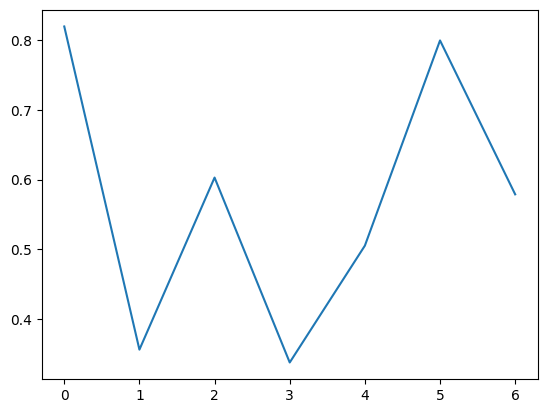

Depth Score Plot:


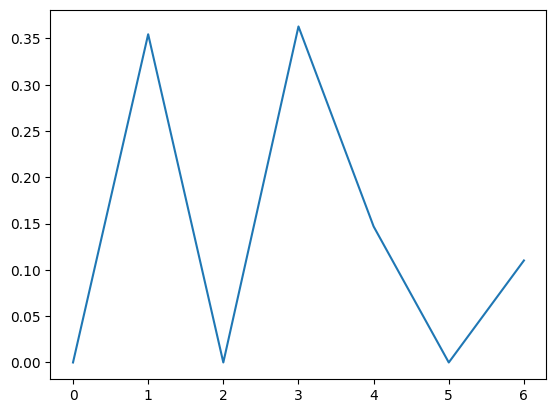

Filtered Depth Score Plot:


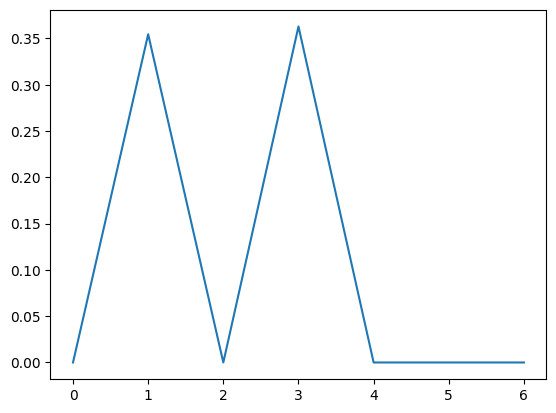

Filtered Depth Score With Threshold Line Plot:


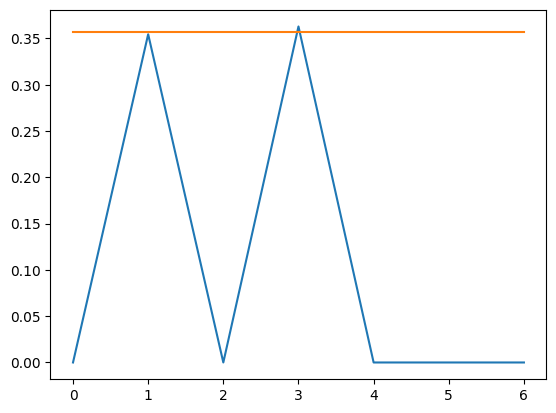

['Tax subsidy is given and', 'flight tickets fees are covered']

In [223]:
semantic_segmentation_function(get_sentence_embedding_MiniLM_L6_v2, "Tax subsidy is given and flight tickets fees are covered", graph_status=True)

Coherence Score Plot:


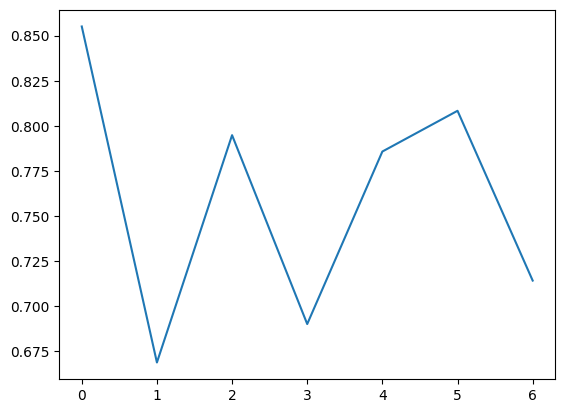

Depth Score Plot:


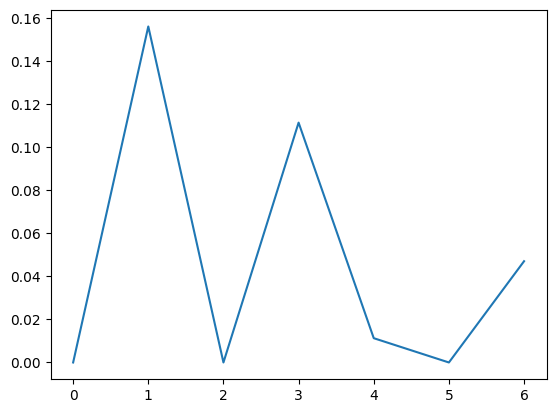

Filtered Depth Score Plot:


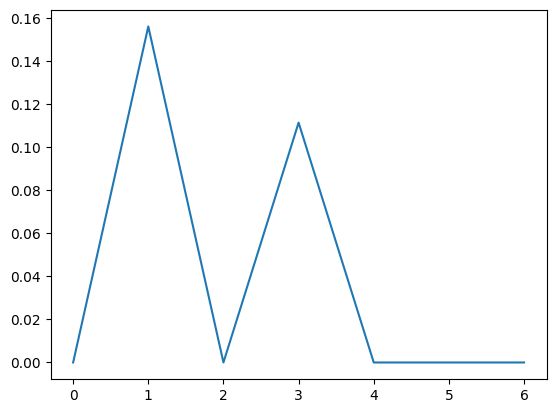

Filtered Depth Score With Threshold Line Plot:


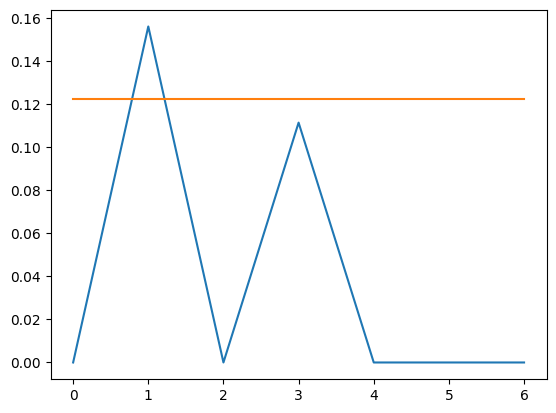

['Tax subsidy is', 'given and flight tickets fees are covered']

In [224]:
semantic_segmentation_function(get_sentence_embedding_bge, "Tax subsidy is given and flight tickets fees are covered", graph_status=True)

In [13]:
def categories_wsub_similarity_comparison_function(embedding_model_function, categories_wsub_dict, texts, sort_output=0):
    categories_wsub_result_dict = {}
    for big_general_category, sub_categories in categories_wsub_dict.items():
        categories_wsub_result_dict[big_general_category] = categories_similarity_comparison_function(embedding_model_function=embedding_model_function, categories=([big_general_category]+sub_categories), texts=texts, sort_output=sort_output)
    return categories_wsub_result_dict

def categories_wsub_similarity_result_display(categories_wsub_result_dict, sort_display = 0):
    for big_general_category, big_wsub_categories_result in categories_wsub_result_dict.items():
        print(f"General Category: {big_general_category}")
        categories_similarity_result_display(big_wsub_categories_result, sort_display=sort_display)
        print()
        
def split_and_compare_wsub(split_embed_function, compare_embed_function, categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    compare_result = categories_wsub_similarity_comparison_function(embedding_model_function=compare_embed_function, categories_wsub_dict=categories_wsub, texts=splitted_sentence_text, sort_output=sort_compare)
    if display_end:
        categories_wsub_similarity_result_display(compare_result, sort_display=sort_display)
    return splitted_sentence_text, compare_result

In [14]:
cat_wsub_demo = {"Passage provided for business purpose": ["Air tickets for business trip", "Air tickets for work purposes", "Flight for business trip", "Flight for work purposes", "Travel incidental to employment"],
            "Passage provided when taking up employment and upon termination": ["Air tickets back to home country after contract end", "Air tickets back to home country after termination of employment", "Air tickets to work in Singapore", "Flight back to home country after contract end", "Flight back to home country after termination of employment", "Flight to work in Singapore"],
            "Home leave passage": ["Air passage benefit", "Air tickets to home country", "Flight to home country"]}
hlp_biz_demo = "Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips"

In [239]:
split_and_compare_wsub(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
free flight benefits for busin /-/ Passage provided for business  : 0.29568
to return to home country once /-/ Passage provided for business  : 0.17853
Employees receive free flight  /-/ Passage provided for business  : 0.14779
a year and                     /-/ Passage provided for business  : 0.065523
Category: Air tickets for business trip
Similarity Level:
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
Employees receive free flight  /-/ Air tickets for business trip  : 0.46398
to return to home country once /-/ Air tickets for business trip  : 0.11836
a year and                     /-/ Air tickets for business trip  : 0.050477
Category: Air tickets for work purposes
Similarity Level:
Em

In [236]:
split_and_compare_wsub(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_bge, cat_wsub_demo, hlp_biz_demo, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
free flight benefits for busin /-/ Passage provided for business  : 0.60146
to return to home country once /-/ Passage provided for business  : 0.55901
Employees receive free flight  /-/ Passage provided for business  : 0.52735
a year and                     /-/ Passage provided for business  : 0.49561
Category: Air tickets for business trip
Similarity Level:
free flight benefits for busin /-/ Air tickets for business trip  : 0.80979
Employees receive free flight  /-/ Air tickets for business trip  : 0.66801
to return to home country once /-/ Air tickets for business trip  : 0.57646
a year and                     /-/ Air tickets for business trip  : 0.39768
Category: Air tickets for work purposes
Similarity Level:
free

In [237]:
split_and_compare_wsub(get_sentence_embedding_bge, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
free flight benefits for busin /-/ Passage provided for business  : 0.29568
Employees receive free flight  /-/ Passage provided for business  : 0.16618
a year and                     /-/ Passage provided for business  : 0.065523
return to home country once    /-/ Passage provided for business  : 0.039441
Category: Air tickets for business trip
Similarity Level:
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
Employees receive free flight  /-/ Air tickets for business trip  : 0.46172
return to home country once    /-/ Air tickets for business trip  : 0.081763
a year and                     /-/ Air tickets for business trip  : 0.050477
Category: Air tickets for work purposes
Similarity Level:


In [238]:
split_and_compare_wsub(get_sentence_embedding_bge, get_sentence_embedding_bge, cat_wsub_demo, hlp_biz_demo, sort_display=-1)
pass

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
free flight benefits for busin /-/ Passage provided for business  : 0.60146
Employees receive free flight  /-/ Passage provided for business  : 0.54829
return to home country once    /-/ Passage provided for business  : 0.54396
a year and                     /-/ Passage provided for business  : 0.49561
Category: Air tickets for business trip
Similarity Level:
free flight benefits for busin /-/ Air tickets for business trip  : 0.80979
Employees receive free flight  /-/ Air tickets for business trip  : 0.70321
return to home country once    /-/ Air tickets for business trip  : 0.57358
a year and                     /-/ Air tickets for business trip  : 0.39768
Category: Air tickets for work purposes
Similarity Level:
Empl

### Top (count) & Limit (value)

In [15]:
## top few, but no point if bottom so dw? and no sort is no point? cos need sort to determine top anyway!!!

def categories_similarity_result_display_top_limit(categories_result_dict, top_many = 5, limit_value = 0.5):
    for category, category_similarity_results_dict in categories_result_dict.items():
        print(f"Sub-Categories: {category}")
        print(f"Similarity Level Of Top {top_many} (Limit={limit_value}):")
        num_count = 0
        #if sort_display == -1:
        for comparison_items_tuple, comparison_result in (sorted(category_similarity_results_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
            if num_count == top_many or comparison_result < limit_value:
                break
            print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
            num_count += 1
        """
        elif sort_display == 1:
            for comparison_items_tuple, comparison_result in (sorted(category_similarity_results_dict.items(), key= lambda dict_item: dict_item[1], reverse=True)):
                if num_count == top_many or comparison_result < limit_value:
                    break
                print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
        else:
            for comparison_items_tuple, comparison_result in category_similarity_results_dict.items():
                if num_count == top_many or comparison_result < limit_value:
                    break
                print(f"{comparison_items_tuple[0]:30.30} /-/ {comparison_items_tuple[1]:30.30} : {comparison_result:.5}")
        """
def categories_wsub_similarity_result_display_top_limit(categories_wsub_result_dict, top_many = 5, limit_value = 0.5):
    for big_general_category, big_wsub_categories_result in categories_wsub_result_dict.items():
        print(f"General Category: {big_general_category}")
        general_category_subcats = tuple(big_wsub_categories_result.keys())
        subcat_combined_dicts = {}
        for subcat_dicts in big_wsub_categories_result.values():
            subcat_combined_dicts = subcat_combined_dicts | subcat_dicts
        #sorted_subcat_combined_dicts = {comp_tuple:comp_res for comp_tuple, comp_res in sorted(subcat_combined_dicts.items(), key = lambda dict_item: dict_item[1], reverse=True)}
        categories_similarity_result_display_top_limit({general_category_subcats: subcat_combined_dicts}, top_many=top_many, limit_value=limit_value)
        print()
        
def split_and_compare_wsub_top_limit(split_embed_function, compare_embed_function, categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, top_many = 5, limit_value = 0.5):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    compare_result = categories_wsub_similarity_comparison_function(embedding_model_function=compare_embed_function, categories_wsub_dict=categories_wsub, texts=splitted_sentence_text, sort_output=sort_compare)
    if display_end:
        categories_wsub_similarity_result_display_top_limit(compare_result, top_many=top_many, limit_value=limit_value)
    return splitted_sentence_text, compare_result

In [48]:
split_and_compare_wsub_top_limit(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.5)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [ ]:
def split_and_compare(split_embed_function, compare_embed_function, categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
def split_and_compare_wsub(split_embed_function, compare_embed_function, categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
def split_and_compare_wsub_top_limit(split_embed_function, compare_embed_function, categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, top_many = 5, limit_value = 0.5):

### Locks for Split and Compare (and variations-> normal, wsub, top limit)

In [65]:
def lock_split_and_compare(split_embed_function, compare_embed_function):
    def lockED_split_and_compare(categories, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
        return split_and_compare(split_embed_function, compare_embed_function, categories, sentence_text, intermediate = intermediate, graph = graph, sort_compare = sort_compare, display_split = display_split , display_end = display_end, sort_display = sort_display)
    return lockED_split_and_compare
def lock_split_and_compare_wsub(split_embed_function, compare_embed_function):
    def lockED_split_and_compare_wsub(categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, sort_display = 0):
        return split_and_compare_wsub(split_embed_function, compare_embed_function, categories_wsub=categories_wsub, sentence_text=sentence_text, intermediate = intermediate, graph = graph, sort_compare = sort_compare, display_split = display_split , display_end = display_end, sort_display = sort_display)
    return lockED_split_and_compare_wsub
def lock_split_and_compare_wsub_top_limit(split_embed_function, compare_embed_function):
    return lambda categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, display_split = True , display_end = True, top_many = 5, limit_value = 0.5:split_and_compare_wsub_top_limit(split_embed_function=split_embed_function, compare_embed_function=compare_embed_function, categories_wsub=categories_wsub, sentence_text=sentence_text, intermediate = intermediate, graph = graph, sort_compare = sort_compare, display_split = display_split , display_end = display_end, top_many = top_many, limit_value = limit_value)
        


In [52]:
minilm62_bge_s_c1 = lock_split_and_compare(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_bge)
bge_minilm62_s_c2 = lock_split_and_compare_wsub(get_sentence_embedding_bge, get_sentence_embedding_MiniLM_L6_v2)

minilm62_minilm62_s_c3 = lock_split_and_compare_wsub_top_limit(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2)
bge_bge_s_c3 = lock_split_and_compare_wsub_top_limit(get_sentence_embedding_bge, get_sentence_embedding_bge)

In [71]:
minilm62_bge_s_c1(list(cat_wsub_demo.keys())[0], hlp_biz_demo, )

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Similarity Level:
Employees receive free flight  /-/ Passage provided for business  : 0.52735
to return to home country once /-/ Passage provided for business  : 0.55901
a year and                     /-/ Passage provided for business  : 0.49561
free flight benefits for busin /-/ Passage provided for business  : 0.60146


(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {('Employees receive free flight benefits',
    'Passage provided for business purpose'): 0.5273454640409909,
   ('to return to home country once',
    'Passage provided for business purpose'): 0.5590083551667142,
   ('a year and', 'Passage provided for business purpose'): 0.4956094203318848,
   ('free flight benefits for business trips',
    'Passage provided for business purpose'): 0.6014551911575552}})

# 

In [57]:
bge_minilm62_s_c2(cat_wsub_demo, hlp_biz_demo)
pass

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
Employees receive free flight  /-/ Passage provided for business  : 0.16618
return to home country once    /-/ Passage provided for business  : 0.039441
a year and                     /-/ Passage provided for business  : 0.065523
free flight benefits for busin /-/ Passage provided for business  : 0.29568
Category: Air tickets for business trip
Similarity Level:
Employees receive free flight  /-/ Air tickets for business trip  : 0.46172
return to home country once    /-/ Air tickets for business trip  : 0.081763
a year and                     /-/ Air tickets for business trip  : 0.050477
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
Category: Air tickets for work purposes
Similarity Level:


In [73]:
bge_bge_s_c3(cat_wsub_demo, hlp_biz_demo, top_many=3)
pass

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.81393
free flight benefits for busin /-/ Air tickets for business trip  : 0.80979
free flight benefits for busin /-/ Flight for work purposes       : 0.77811

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [74]:
minilm62_minilm62_s_c3(cat_wsub_demo, hlp_biz_demo, top_many=3)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [65]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    """
    print(attention_mask.shape, attention_mask)
    print(attention_mask.unsqueeze(-1).shape, attention_mask.unsqueeze(-1))
    print(input_mask_expanded)
    print(len(input_mask_expanded), token_embeddings.size(), input_mask_expanded.size())
    """
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

"""
# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']
"""

# Load model from HuggingFace Hub
pt_transformers_L6_v2_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
pt_transformers_L6_v2_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

def pt_transformers_method_embedding_L6_v2(sentences):
    
    # Tokenize sentences
    encoded_input = pt_transformers_L6_v2_tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = pt_transformers_L6_v2_model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    #print("Sentence embeddings:")
    #print(sentence_embeddings)
    '''
    if len(sentence_embeddings) == 1:
        return sentence_embeddings[0]
    return sentence_embeddings
    '''
    return sentence_embeddings

In [66]:
split_and_compare_wsub_top_limit(pt_transformers_method_embedding_L6_v2, pt_transformers_method_embedding_L6_v2, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962
Employees receive free flight  /-/ Flight for work purposes       : 0.55113
Employees receive free flight  /-/ Air tickets for work purposes  : 0.53761

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termina

(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.14779233235003653,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.17852770986928615,
    ('a year and',
     'Passage provided for business purpose'): 0.06552286772996774,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.29568490649739965},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.4639808954117372,
    ('to return to home country once',
     'Air tickets for business trip'): 0.11835617757300575,
    ('a year and', 'Air tickets for business trip'): 0.0504765864001799,
    ('free flight benefits for business

In [93]:
pt_transformers_method_embedding_L6_v2("hi there")

tensor([-1.0393e-01,  2.0046e-02,  1.5061e-02,  1.6006e-02, -1.1926e-02,
        -6.6343e-02,  5.0125e-02,  6.1243e-02,  2.4817e-02,  1.9213e-03,
        -8.4717e-03, -4.8424e-03, -4.3445e-02, -3.3344e-02,  2.9367e-02,
         5.1366e-02, -1.7148e-02, -4.2455e-02, -1.6554e-01, -4.9113e-02,
         1.6032e-02,  8.1117e-02, -1.2132e-01,  2.6499e-02, -4.1076e-02,
        -3.9687e-02,  6.7479e-03,  8.6902e-02, -6.3226e-02, -2.6693e-03,
         2.1978e-02,  6.1469e-02,  2.0521e-02,  3.6933e-02,  3.3248e-02,
         3.0363e-02, -4.5100e-02, -6.6769e-02,  3.2899e-02,  1.4454e-02,
         1.6767e-03, -8.0434e-03, -1.1684e-02,  3.3987e-02,  5.4519e-02,
        -8.8126e-02,  1.4727e-02, -8.6807e-02,  2.6017e-02,  3.5282e-02,
        -5.4358e-02, -2.1229e-02, -5.5936e-02, -3.9887e-02,  1.2032e-01,
         1.0564e-02, -8.4991e-03, -5.9975e-02,  7.5582e-02, -5.7824e-02,
        -4.8444e-02,  1.2304e-02, -9.6453e-02, -3.7179e-02,  1.7875e-02,
        -3.1692e-02, -3.5624e-02, -6.9730e-02, -2.6

In [94]:
split_and_compare_wsub_top_limit(pt_transformers_method_embedding_L6_v2, pt_transformers_method_embedding_L6_v2, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962
Employees receive free flight  /-/ Flight for work purposes       : 0.55113
Employees receive free flight  /-/ Air tickets for work purposes  : 0.53761

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termina

(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.14779233235003653,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.17852770986928615,
    ('a year and',
     'Passage provided for business purpose'): 0.06552286772996774,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.29568490649739965},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.4639808954117372,
    ('to return to home country once',
     'Air tickets for business trip'): 0.11835617757300575,
    ('a year and', 'Air tickets for business trip'): 0.0504765864001799,
    ('free flight benefits for business

### Locks for Split and Compare (and variations-> normal, wsub, top limit)

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    """
    print(attention_mask.shape, attention_mask)
    print(attention_mask.unsqueeze(-1).shape, attention_mask.unsqueeze(-1))
    print(input_mask_expanded)
    print(len(input_mask_expanded), token_embeddings.size(), input_mask_expanded.size())
    """
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

"""
# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']
"""

# Load model from HuggingFace Hub
pt_transformers_L12_v2_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')
pt_transformers_L12_v2_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L12-v2')

def pt_transformers_method_embedding_L12_v2(sentences):


    # Tokenize sentences
    encoded_input = pt_transformers_L12_v2_tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = pt_transformers_L12_v2_model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    #print("Sentence embeddings:")
    #print(sentence_embeddings)
    '''
    if len(sentence_embeddings) == 1:
        return sentence_embeddings[0]
    return sentence_embeddings
    '''
    return sentence_embeddings

In [68]:
split_and_compare_wsub_top_limit(pt_transformers_method_embedding_L12_v2, pt_transformers_method_embedding_L12_v2, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.76484
free flight benefits for busin /-/ Air tickets for business trip  : 0.66527
free flight benefits for busin /-/ Flight for work purposes       : 0.66138
Employees receive free flight  /-/ Flight for work purposes       : 0.62341
free flight benefits for busin /-/ Air tickets for work purposes  : 0.54205

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termina

(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.20551156271491777,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.1994273430746034,
    ('a year and',
     'Passage provided for business purpose'): 0.08857028789225296,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.38571809703989857},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.433589215434381,
    ('to return to home country once',
     'Air tickets for business trip'): 0.1820303924532709,
    ('a year and', 'Air tickets for business trip'): 0.07098160516875396,
    ('free flight benefits for business t

In [52]:
from transformers import CanineTokenizer, CanineModel

Canine_model = CanineModel.from_pretrained('google/canine-c')
Canine_tokenizer = CanineTokenizer.from_pretrained('google/canine-c')

def g_canine_embedding(sentences_input):
    #sentences_input = ["Life is like a box of chocolates.", "You never know what you gonna get."]
    encoding = Canine_tokenizer(sentences_input, padding="longest", truncation=True, return_tensors="pt")

    outputs = Canine_model(**encoding) # forward pass
    pooled_output = outputs.pooler_output
    #print(pooled_output)
    sequence_output = outputs.last_hidden_state
    
    """
    sentence_cls_emb = mean_pooling(outputs, encoding["attention_mask"])
    sentence_cls_emb = F.normalize(sentence_cls_emb, p=2, dim=1)

    if len(sentence_cls_emb) == 1:
        return sentence_cls_emb[0]
    return sentence_cls_emb
    """
    
    '''
    if len(sequence_output) == 1:
        return sequence_output[0][0]
    return sequence_output[:, 0]
    '''
    return sequence_output[:, 0]

In [62]:
split_and_compare_wsub_top_limit(g_canine_embedding, g_canine_embedding, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits to return to home country once a', 'year and free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
Employees receive free flight  /-/ Air tickets for business trip  : 0.75359
Employees receive free flight  /-/ Travel incidental to employmen : 0.7293
year and free flight benefits  /-/ Air tickets for business trip  : 0.71131
Employees receive free flight  /-/ Air tickets for work purposes  : 0.70526
Employees receive free flight  /-/ Flight for business trip       : 0.69603

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 

(['Employees receive free flight benefits to return to home country once a',
  'year and free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits to return to home country once a',
     'Passage provided for business purpose'): 0.5724202551388942,
    ('year and free flight benefits for business trips',
     'Passage provided for business purpose'): 0.5559157815014828},
   'Air tickets for business trip': {('Employees receive free flight benefits to return to home country once a',
     'Air tickets for business trip'): 0.7535948067945748,
    ('year and free flight benefits for business trips',
     'Air tickets for business trip'): 0.7113087463084469},
   'Air tickets for work purposes': {('Employees receive free flight benefits to return to home country once a',
     'Air tickets for work purposes'): 0.7052566583417246,
    ('year and free flight benefits for business trip

In [58]:
g_canine_embedding(["hi there", "jack", "back"])

tensor([[ 0.1806, -0.2008, -0.1556,  ...,  0.2942,  0.0486,  0.0419],
        [ 0.0515, -0.1447,  0.3480,  ..., -0.1419,  0.6230,  0.0869],
        [-0.0242,  0.0269,  0.4086,  ..., -0.0584,  0.4369, -0.0983]],
       grad_fn=<SelectBackward0>)

In [124]:
split_and_compare_wsub_top_limit(g_canine_embedding, g_canine_embedding, cat_wsub_demo, hlp_biz_demo)
pass

Splitted texts: ['Employees receive free flight benefits to return to home country once a', 'year and free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
Employees receive free flight  /-/ Air tickets for business trip  : 0.75359
Employees receive free flight  /-/ Travel incidental to employmen : 0.7293
year and free flight benefits  /-/ Air tickets for business trip  : 0.71131
Employees receive free flight  /-/ Air tickets for work purposes  : 0.70526
Employees receive free flight  /-/ Flight for business trip       : 0.69603

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 

In [131]:
split_and_compare_wsub_top_limit(get_sentence_embedding_bge, get_sentence_embedding_bge, cat_wsub_demo, hlp_biz_demo)

Splitted texts: ['Employees receive free flight benefits to', 'return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.81393
free flight benefits for busin /-/ Air tickets for business trip  : 0.80979
free flight benefits for busin /-/ Flight for work purposes       : 0.77811
Employees receive free flight  /-/ Flight for work purposes       : 0.7757
Employees receive free flight  /-/ Air tickets for work purposes  : 0.72803

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon terminat

(['Employees receive free flight benefits to',
  'return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits to',
     'Passage provided for business purpose'): 0.548290666637044,
    ('return to home country once',
     'Passage provided for business purpose'): 0.5439581575519554,
    ('a year and',
     'Passage provided for business purpose'): 0.4956094203318848,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.6014551911575552},
   'Air tickets for business trip': {('Employees receive free flight benefits to',
     'Air tickets for business trip'): 0.7032104297015636,
    ('return to home country once',
     'Air tickets for business trip'): 0.5735795183705736,
    ('a year and', 'Air tickets for business trip'): 0.39768120289318176,
    ('free flight benefits for business trip

In [127]:
## trying out mxbai-embed-large-v1

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sentence_transformers.quantization import quantize_embeddings

# 1. Specify preffered dimensions
mxbai_v1_dimensions = 512

# 2. load model
mxbai_v1_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=mxbai_v1_dimensions)

def mxbai_embed(sentences):
    # For retrieval you need to pass this prompt.
    query = 'Represent this sentence for searching relevant passages: A man is eating a piece of bread'

    docs = sentences

    # 2. Encode
    embeddings = mxbai_v1_model.encode(docs)

    # Optional: Quantize the embeddings
    #binary_embeddings = quantize_embeddings(embeddings, precision="ubinary")

    #similarities = cos_sim(embeddings[0], embeddings[1:])
    #print('similarities:', similarities)
    return embeddings
'''
def mxbai_embed_retrieval(sentences):
    # For retrieval you need to pass this prompt.
    query = 'Represent this sentence for searching relevant passages: A man is eating a piece of bread'

    docs = sentences

    # 2. Encode
    embeddings = mxbai_v1_model.encode(docs)

    # Optional: Quantize the embeddings
    #binary_embeddings = quantize_embeddings(embeddings, precision="ubinary")

    #similarities = cos_sim(embeddings[0], embeddings[1:])
    #print('similarities:', similarities)
    return embeddings
'''

c:\Users\Audric Ho\Downloads\LLM related stuff\semantic_text_segmentation_attempt\semantic_seg-venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [129]:
mxbai_embed(["hi there", "jack"])

array([[ 0.5805947 ,  0.09685631,  0.05187155, ...,  0.36956686,
         0.11387055,  0.18510513],
       [ 0.08705159, -0.4488235 ,  0.12563783, ..., -0.21094385,
        -0.22387232,  0.154229  ]], dtype=float32)

In [130]:
split_and_compare_wsub_top_limit(mxbai_embed, mxbai_embed, cat_wsub_demo, hlp_biz_demo)


Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 5 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.81268
free flight benefits for busin /-/ Air tickets for business trip  : 0.80278
free flight benefits for busin /-/ Flight for work purposes       : 0.76816
Employees receive free flight  /-/ Flight for work purposes       : 0.74621
Employees receive free flight  /-/ Air tickets for work purposes  : 0.72227

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termina

(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.4135557431587529,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.4630591356629168,
    ('a year and',
     'Passage provided for business purpose'): 0.4057218914706482,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.533218416721752},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.6836688737527084,
    ('to return to home country once',
     'Air tickets for business trip'): 0.5522138716750078,
    ('a year and', 'Air tickets for business trip'): 0.2740071568051974,
    ('free flight benefits for business trips

In [132]:
cat_wsub_demo

{'Passage provided for business purpose': ['Air tickets for business trip',
  'Air tickets for work purposes',
  'Flight for business trip',
  'Flight for work purposes',
  'Travel incidental to employment'],
 'Passage provided when taking up employment and upon termination': ['Air tickets back to home country after contract end',
  'Air tickets back to home country after termination of employment',
  'Air tickets to work in Singapore',
  'Flight back to home country after contract end',
  'Flight back to home country after termination of employment',
  'Flight to work in Singapore'],
 'Home leave passage': ['Air passage benefit',
  'Air tickets to home country',
  'Flight to home country']}

In [133]:
hlp_biz_demo

'Employees receive free flight benefits to return to home country once a year and free flight benefits for business trips'

In [139]:
split_and_compare_wsub_top_limit(pt_transformers_method_embedding_L12_v2, pt_transformers_method_embedding_L12_v2, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.6)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.6):
free flight benefits for busin /-/ Flight for business trip       : 0.76484
free flight benefits for busin /-/ Air tickets for business trip  : 0.66527
free flight benefits for busin /-/ Flight for work purposes       : 0.66138

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [136]:
split_and_compare_wsub_top_limit(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.5)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [144]:
cat_wsub_demo["Home leave passage"].append("return home country")

In [150]:
cat_wsub_demo

{'Passage provided for business purpose': ['Air tickets for business trip',
  'Air tickets for work purposes',
  'Flight for business trip',
  'Flight for work purposes',
  'Travel incidental to employment'],
 'Passage provided when taking up employment and upon termination': ['Air tickets back to home country after contract end',
  'Air tickets back to home country after termination of employment',
  'Air tickets to work in Singapore',
  'Flight back to home country after contract end',
  'Flight back to home country after termination of employment',
  'Flight to work in Singapore'],
 'Home leave passage': ['Air passage benefit',
  'Air tickets to home country',
  'Flight to home country']}

In [147]:
split_and_compare_wsub_top_limit(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.5)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
free flight benefits for busin /-/ Flight for business trip       : 0.75365
free flight benefits for busin /-/ Air tickets for business trip  : 0.65982
free flight benefits for busin /-/ Flight for work purposes       : 0.60962

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work i

In [34]:
hlp_biz_demo_cut_third = [hlp_biz_demo[:len(hlp_biz_demo)//3-1], hlp_biz_demo[len(hlp_biz_demo)//3-1:-len(hlp_biz_demo)//3], hlp_biz_demo[-len(hlp_biz_demo)//3:]]
hlp_biz_demo_cut_third

['Employees receive free flight benefits ',
 'to return to home country once a year and',
 ' free flight benefits for business trips']

In [35]:
categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo_cut_third)

{'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits ',
    'Passage provided for business purpose'): 0.14779233235003653,
   ('to return to home country once a year and',
    'Passage provided for business purpose'): 0.23613265901235564,
   (' free flight benefits for business trips',
    'Passage provided for business purpose'): 0.29568490649739965},
  'Air tickets for business trip': {('Employees receive free flight benefits ',
    'Air tickets for business trip'): 0.4639808954117372,
   ('to return to home country once a year and',
    'Air tickets for business trip'): 0.14540735152911588,
   (' free flight benefits for business trips',
    'Air tickets for business trip'): 0.6598189842771236},
  'Air tickets for work purposes': {('Employees receive free flight benefits ',
    'Air tickets for work purposes'): 0.5376104533584114,
   ('to return to home country once a year and',
    'Air tickets for work purpos

In [36]:
categories_wsub_similarity_result_display(categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo_cut_third), sort_display=-1)

General Category: Passage provided for business purpose
Category: Passage provided for business purpose
Similarity Level:
 free flight benefits for busi /-/ Passage provided for business  : 0.29568
to return to home country once /-/ Passage provided for business  : 0.23613
Employees receive free flight  /-/ Passage provided for business  : 0.14779
Category: Air tickets for business trip
Similarity Level:
 free flight benefits for busi /-/ Air tickets for business trip  : 0.65982
Employees receive free flight  /-/ Air tickets for business trip  : 0.46398
to return to home country once /-/ Air tickets for business trip  : 0.14541
Category: Air tickets for work purposes
Similarity Level:
Employees receive free flight  /-/ Air tickets for work purposes  : 0.53761
 free flight benefits for busi /-/ Air tickets for work purposes  : 0.49501
to return to home country once /-/ Air tickets for work purposes  : 0.17532
Category: Flight for business trip
Similarity Level:
 free flight benefits for

In [38]:
categories_wsub_similarity_result_display_top_limit(categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo_cut_third), top_many=3, limit_value=0.55)

General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.55):
 free flight benefits for busi /-/ Flight for business trip       : 0.75365
 free flight benefits for busi /-/ Air tickets for business trip  : 0.65982
 free flight benefits for busi /-/ Flight for work purposes       : 0.60962

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work in Singapore', 'Flight back to home country after contract end', 'Flight back to home country after termination of employment', 'Flight to work in Sin

In [17]:
from transformers import BartTokenizer, BartModel
import torch

bart_large_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
bart_large_model = BartModel.from_pretrained('facebook/bart-large')
def bart_cls_emb(sentences):
    inputs = bart_large_tokenizer(sentences, return_tensors="pt")
    outputs = bart_large_model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states[:, 0]

def bart_mean_emb(sentences):
    inputs = bart_large_tokenizer(sentences, return_tensors="pt")
    outputs = bart_large_model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_states.size()).float()

    return torch.sum(last_hidden_states * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
def bart_pad_cls_emb(sentences):
    inputs = bart_large_tokenizer(sentences, return_tensors="pt", padding=True)
    outputs = bart_large_model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states[:, 0]

def bart_pad_mean_emb(sentences):
    inputs = bart_large_tokenizer(sentences, return_tensors="pt", padding=True)
    outputs = bart_large_model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_states.size()).float()

    return torch.sum(last_hidden_states * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [21]:
split_and_compare_wsub_top_limit(bart_pad_cls_emb, bart_pad_cls_emb, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.5)

Splitted texts: ['Employees receive free flight benefits', 'to return', 'to home country once a year and free flight benefits', 'for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
Employees receive free flight  /-/ Flight for work purposes       : 0.80317
Employees receive free flight  /-/ Flight for business trip       : 0.79323
Employees receive free flight  /-/ Passage provided for business  : 0.7903

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work in

(['Employees receive free flight benefits',
  'to return',
  'to home country once a year and free flight benefits',
  'for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.7902990436072315,
    ('to return', 'Passage provided for business purpose'): 0.6902611310955061,
    ('to home country once a year and free flight benefits',
     'Passage provided for business purpose'): 0.6613507496241375,
    ('for business trips',
     'Passage provided for business purpose'): 0.6965532127973972},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.7370121021755862,
    ('to return', 'Air tickets for business trip'): 0.6122386767438721,
    ('to home country once a year and free flight benefits',
     'Air tickets for business trip'): 0.631684232227899,
    ('for business trips',
  

In [22]:
split_and_compare_wsub_top_limit(bart_pad_mean_emb, bart_pad_mean_emb, cat_wsub_demo, hlp_biz_demo, top_many=3, limit_value=0.5)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and free flight benefits', 'for business trips']
General Category: Passage provided for business purpose
Sub-Categories: ('Passage provided for business purpose', 'Air tickets for business trip', 'Air tickets for work purposes', 'Flight for business trip', 'Flight for work purposes', 'Travel incidental to employment')
Similarity Level Of Top 3 (Limit=0.5):
for business trips             /-/ Flight for work purposes       : 0.70483
for business trips             /-/ Air tickets for work purposes  : 0.69055
for business trips             /-/ Flight for business trip       : 0.6855

General Category: Passage provided when taking up employment and upon termination
Sub-Categories: ('Passage provided when taking up employment and upon termination', 'Air tickets back to home country after contract end', 'Air tickets back to home country after termination of employment', 'Air tickets to work in

(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and free flight benefits',
  'for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.6019886406371544,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.5072216503016165,
    ('a year and free flight benefits',
     'Passage provided for business purpose'): 0.6119562651755075,
    ('for business trips',
     'Passage provided for business purpose'): 0.6449822851759062},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.6203113367825421,
    ('to return to home country once',
     'Air tickets for business trip'): 0.4860382204465097,
    ('a year and free flight benefits',
     'Air tickets for business trip'): 0.6350631382538339,
    ('for business

In [24]:
from transformers import pipeline
bart_mnli_classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [27]:
def classify_sentence(classifier, candidate_labels, sequence_to_classify, multi_label = True):
    result_dict = {}
    classifier_results = classifier(sequence_to_classify, candidate_labels, multi_label=multi_label)
    if type(classifier_results) != list:
        classifier_results = [classifier_results]
    for classifier_result in classifier_results:
        result_dict[classifier_result["sequence"]] = {label:label_prob for label,label_prob in zip(classifier_result["labels"], classifier_result["scores"])}
    return result_dict
def lock_classify_sentence(classifier):
    return lambda candidate_labels, sequence_to_classify, multi_label = True: classify_sentence(classifier=classifier, candidate_labels=candidate_labels, sequence_to_classify=sequence_to_classify, multi_label=multi_label)

In [95]:
#categories_classification_function(classification_model_function=classification_model_function, categories=categories, texts=splitted_sentence_text, sort_output=sort_compare)
def categories_classification_function(classification_model_function, categories_candidate_labels, texts, multi_label = True, sort_output = 0):
    classification_results = classify_sentence(classifier=classification_model_function, candidate_labels=categories_candidate_labels, sequence_to_classify=texts, multi_label=multi_label)
    final_classified_dict = {}
    if sort_output == -1:
        final_classified_dict = classification_results
        return final_classified_dict
    if sort_output == 0:
        for seq in texts:
            final_classified_dict[seq] = {label:classification_results[seq][label] for label in categories_candidate_labels}
        return final_classified_dict
    if sort_output == 1:
        for seq in texts:
            pre_sort = {label:classification_results[seq][label] for label in categories_candidate_labels}
            final_classified_dict[seq] = {label:label_pred for label, label_pred in sorted(pre_sort.items(), key = lambda dict_item: dict_item[1])}
        return final_classified_dict
    
def categories_classification_additional_resort_function(seq_classified_dictionary, categories_candidate_labels, sort_output = 0, top_many = 5, limit_value = 0.5):
    if limit_value < 0:
        if sort_output == -1:
            limit_value = 0
        if sort_output == 0:
            limit_value = None
        if sort_output == 1:
            limit_value = 1
    resorted_classification_dict = {label:{} for label in categories_candidate_labels}
    for seq, label_to_label_pred_dict in seq_classified_dictionary.items():
        for label in categories_candidate_labels:
            if sort_output == -1:
                if label_to_label_pred_dict[label] >= limit_value:
                    resorted_classification_dict[label][seq] = label_to_label_pred_dict[label]
            if sort_output == 0:
                # limit_value no meaning here since no sorting so no >= or <= to base off
                resorted_classification_dict[label][seq] = label_to_label_pred_dict[label]
            if sort_output == 1:
                if label_to_label_pred_dict[label] <= limit_value:
                    resorted_classification_dict[label][seq] = label_to_label_pred_dict[label]
    if sort_output == -1:
        for label in categories_candidate_labels:
            resorted_classification_dict[label] = dict(sorted(resorted_classification_dict[label].items(), key = lambda dict_item: dict_item[1], reverse=True))
    if sort_output == 0:
        resorted_classification_dict = resorted_classification_dict
    if sort_output == 1:
        for label in categories_candidate_labels:
            resorted_classification_dict[label] = dict(sorted(resorted_classification_dict[label].items(), key = lambda dict_item: dict_item[1], reverse=False))
    
    if top_many >= 0:
        for label in categories_candidate_labels:
            resorted_classification_dict[label] = dict(list(resorted_classification_dict[label].items())[:top_many])
    return resorted_classification_dict

In [189]:
def categories_classification_resorted_result_display(classification_resorted_dictionary_result, sort_display = 0, top_many = 5, limit_value = 0.5):
    if limit_value < 0:
        if sort_display == -1:
            limit_value = 0
        if sort_display == 0:
            limit_value = None
        if sort_display == 1:
            limit_value = 1
    if top_many > 0:
        for label, seq_pred_dict in classification_resorted_dictionary_result.items():
            print(f"Category: {label}")
            if sort_display == -1:
                for seq, pred in dict(sorted(list(seq_pred_dict.items()), key=lambda list_dict_tuple: list_dict_tuple[1], reverse=True)[:top_many]).items():
                    if pred >= limit_value:
                        print(f"{seq:65.65}: {pred:.5}")
            if sort_display == 0:
                ## if no sorting, then top xxx and limit yyy does not make sense so not applicable here
                for seq, pred in seq_pred_dict.items():
                    print(f"{seq:65.65}: {pred:.5}")
            if sort_display == 1:
                for seq, pred in dict(sorted(list(seq_pred_dict.items()), key=lambda list_dict_tuple: list_dict_tuple[1], reverse=False)[:top_many]).items():
                    if pred <= limit_value:
                        print(f"{seq:65.65}: {pred:.5}")
            print()
    else:
        for label, seq_pred_dict in classification_resorted_dictionary_result.items():
            print(f"Category: {label}")
            if sort_display == -1:
                for seq, pred in dict(sorted(seq_pred_dict.items(), key=lambda list_dict_tuple: list_dict_tuple[1], reverse=True)).items():
                    if pred >= limit_value:
                        print(f"{seq:65.65}: {pred:.5}")
            if sort_display == 0:
                ## if no sorting, then top xxx and limit yyy does not make sense so not applicable here
                for seq, pred in seq_pred_dict.items():
                    print(f"{seq:65.65}: {pred:.5}")
            if sort_display == 1:
                for seq, pred in dict(sorted(seq_pred_dict.items(), key=lambda list_dict_tuple: list_dict_tuple[1], reverse=False)).items():
                    if pred <= limit_value:
                        print(f"{seq:65.65}: {pred:.5}")
            print()

In [37]:
candidate_possible_labels = ['travel', 'cooking', 'dancing', 'exploration']
sequences_list = ["one day i will see the world", "i will explore sweden next semester", "I love popping and locking!"]

In [149]:
classify_sentence(bart_mnli_classifier, candidate_possible_labels, sequences_list, multi_label=True)

{'one day i will see the world': {'travel': 0.994157612323761,
  'exploration': 0.92877596616745,
  'dancing': 0.005361784249544144,
  'cooking': 0.0016605753917247057},
 'i will explore sweden next semester': {'travel': 0.9911717772483826,
  'exploration': 0.9684410691261292,
  'dancing': 0.0032393524888902903,
  'cooking': 0.00020078456145711243},
 'I love popping and locking!': {'exploration': 0.7612733244895935,
  'dancing': 0.22573687136173248,
  'cooking': 0.17265444993972778,
  'travel': 0.0074744801968336105}}

In [150]:
classify_sentence(bart_mnli_classifier, candidate_possible_labels, sequences_list[0], multi_label=False)

{'one day i will see the world': {'travel': 0.8104696869850159,
  'exploration': 0.1847233921289444,
  'dancing': 0.0025745946913957596,
  'cooking': 0.0022323287557810545}}

In [38]:
categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1)

{'one day i will see the world': {'travel': 0.994157612323761,
  'exploration': 0.92877596616745,
  'dancing': 0.005361784249544144,
  'cooking': 0.0016605753917247057},
 'i will explore sweden next semester': {'travel': 0.9911717772483826,
  'exploration': 0.9684410691261292,
  'dancing': 0.0032393524888902903,
  'cooking': 0.00020078456145711243},
 'I love popping and locking!': {'exploration': 0.7612733244895935,
  'dancing': 0.22573687136173248,
  'cooking': 0.17265444993972778,
  'travel': 0.0074744801968336105}}

In [66]:
categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=-1, top_many=5, limit_value=0.5)

{'travel': {'one day i will see the world': 0.994157612323761,
  'i will explore sweden next semester': 0.9911717772483826},
 'cooking': {},
 'dancing': {},
 'exploration': {'i will explore sweden next semester': 0.9684410691261292,
  'one day i will see the world': 0.92877596616745,
  'I love popping and locking!': 0.7612733244895935}}

In [190]:
categories_classification_resorted_result_display(categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=-1, top_many=5, limit_value=0.5),sort_display=-1, top_many=-1, limit_value=-1)

Category: travel
one day i will see the world                                     : 0.99416
i will explore sweden next semester                              : 0.99117

Category: cooking

Category: dancing

Category: exploration
i will explore sweden next semester                              : 0.96844
one day i will see the world                                     : 0.92878
I love popping and locking!                                      : 0.76127



In [188]:
# Arguments to use for function
limit_value = 0.1
top_many_cat = 2
get_list = True

cleaned_categories_classification_resorted_result_display(cleaned_classification_resorted_result=categories_classification_additional_resort_cleaning_function(classification_resorted_dictionary_result=categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=-1, top_many=1, limit_value=limit_value), get_list=get_list, top_many_cat=top_many_cat, limit_value=limit_value), get_list=get_list)


Category: travel
one day i will see the world                                     : 0.99416

Category: exploration
i will explore sweden next semester                              : 0.96844



In [39]:
categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=0)

{'one day i will see the world': {'travel': 0.994157612323761,
  'cooking': 0.0016605753917247057,
  'dancing': 0.005361784249544144,
  'exploration': 0.92877596616745},
 'i will explore sweden next semester': {'travel': 0.9911717772483826,
  'cooking': 0.00020078456145711243,
  'dancing': 0.0032393524888902903,
  'exploration': 0.9684410691261292},
 'I love popping and locking!': {'travel': 0.0074744801968336105,
  'cooking': 0.17265444993972778,
  'dancing': 0.22573687136173248,
  'exploration': 0.7612733244895935}}

In [63]:
categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=0), candidate_possible_labels, sort_output=0, top_many=5, limit_value=0.5)

{'travel': {'one day i will see the world': 0.994157612323761,
  'i will explore sweden next semester': 0.9911717772483826},
 'cooking': {},
 'dancing': {},
 'exploration': {'one day i will see the world': 0.92877596616745,
  'i will explore sweden next semester': 0.9684410691261292,
  'I love popping and locking!': 0.7612733244895935}}

In [191]:
categories_classification_resorted_result_display(categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=0, top_many=5, limit_value=0.5),sort_display=0, top_many=-1, limit_value=-1)

Category: travel
one day i will see the world                                     : 0.99416
i will explore sweden next semester                              : 0.99117
I love popping and locking!                                      : 0.0074745

Category: cooking
one day i will see the world                                     : 0.0016606
i will explore sweden next semester                              : 0.00020078
I love popping and locking!                                      : 0.17265

Category: dancing
one day i will see the world                                     : 0.0053618
i will explore sweden next semester                              : 0.0032394
I love popping and locking!                                      : 0.22574

Category: exploration
one day i will see the world                                     : 0.92878
i will explore sweden next semester                              : 0.96844
I love popping and locking!                                      : 0.76127



In [40]:
categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=1)

{'one day i will see the world': {'cooking': 0.0016605753917247057,
  'dancing': 0.005361784249544144,
  'exploration': 0.92877596616745,
  'travel': 0.994157612323761},
 'i will explore sweden next semester': {'cooking': 0.00020078456145711243,
  'dancing': 0.0032393524888902903,
  'exploration': 0.9684410691261292,
  'travel': 0.9911717772483826},
 'I love popping and locking!': {'travel': 0.0074744801968336105,
  'cooking': 0.17265444993972778,
  'dancing': 0.22573687136173248,
  'exploration': 0.7612733244895935}}

In [62]:
categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=1), candidate_possible_labels, sort_output=1, top_many=5, limit_value=0.5)

{'travel': {'i will explore sweden next semester': 0.9911717772483826,
  'one day i will see the world': 0.994157612323761},
 'cooking': {},
 'dancing': {},
 'exploration': {'I love popping and locking!': 0.7612733244895935,
  'one day i will see the world': 0.92877596616745,
  'i will explore sweden next semester': 0.9684410691261292}}

In [192]:
categories_classification_resorted_result_display(categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=1, top_many=5, limit_value=0.5),sort_display=1, top_many=-1, limit_value=-1)

Category: travel
I love popping and locking!                                      : 0.0074745

Category: cooking
i will explore sweden next semester                              : 0.00020078
one day i will see the world                                     : 0.0016606
I love popping and locking!                                      : 0.17265

Category: dancing
i will explore sweden next semester                              : 0.0032394
one day i will see the world                                     : 0.0053618
I love popping and locking!                                      : 0.22574

Category: exploration



In [97]:
def split_and_classify(split_embed_function, classify_function, candidate_possible_labels, sentence_text, intermediate = False, graph = False, multi_label=True, sort_classify = 0, additional_resort = True, display_split = True , display_end = True, sort_display = 0):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    classification_result = categories_classification_function(classification_model_function=classify_function, categories_candidate_labels=candidate_possible_labels, texts=splitted_sentence_text, multi_label=multi_label, sort_output=sort_classify)
    if additional_resort:
        resorted_classification_result = categories_classification_additional_resort_function(seq_classified_dictionary=classification_result, categories_candidate_labels=candidate_possible_labels, sort_output=sort_classify, top_many=-1, limit_value=0)
    if display_end:
        display_usage_resorted_classification_result = categories_classification_additional_resort_function(seq_classified_dictionary=classification_result, categories_candidate_labels=candidate_possible_labels, sort_output=0, top_many=-1, limit_value=-1)
        categories_classification_resorted_result_display(classification_resorted_dictionary_result=display_usage_resorted_classification_result, sort_display=sort_display, top_many=-1, limit_value=-1)
    if additional_resort:
        return splitted_sentence_text, resorted_classification_result
    return splitted_sentence_text, classification_result

def split_and_classify_top_limit(split_embed_function, classify_function, candidate_possible_labels, sentence_text, intermediate = False, graph = False, multi_label=True, sort_classify = 0, additional_resort = True, display_split = True , display_end = True, sort_display = 0, top_many=5, limit_value=0.5):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    classification_result = categories_classification_function(classification_model_function=classify_function, categories_candidate_labels=candidate_possible_labels, texts=splitted_sentence_text, multi_label=multi_label, sort_output=sort_classify)
    if additional_resort:
        resorted_classification_result = categories_classification_additional_resort_function(seq_classified_dictionary=classification_result, categories_candidate_labels=candidate_possible_labels, sort_output=sort_classify, top_many=top_many, limit_value=limit_value)
    if display_end:
        display_usage_resorted_classification_result = categories_classification_additional_resort_function(seq_classified_dictionary=classification_result, categories_candidate_labels=candidate_possible_labels, sort_output=0, top_many=-1, limit_value=-1)
        categories_classification_resorted_result_display(classification_resorted_dictionary_result=display_usage_resorted_classification_result, sort_display=sort_display, top_many=top_many, limit_value=limit_value)
    if additional_resort:
        return splitted_sentence_text, resorted_classification_result
    return splitted_sentence_text, classification_result

In [49]:
new_temp_l = []
for i,j in cat_wsub_demo.items():
    new_temp_l.append(i)
    for k in j:
        new_temp_l.append(k)
new_temp_l

['Passage provided for business purpose',
 'Air tickets for business trip',
 'Air tickets for work purposes',
 'Flight for business trip',
 'Flight for work purposes',
 'Travel incidental to employment',
 'Passage provided when taking up employment and upon termination',
 'Air tickets back to home country after contract end',
 'Air tickets back to home country after termination of employment',
 'Air tickets to work in Singapore',
 'Flight back to home country after contract end',
 'Flight back to home country after termination of employment',
 'Flight to work in Singapore',
 'Home leave passage',
 'Air passage benefit',
 'Air tickets to home country',
 'Flight to home country']

In [57]:
new_temp_l_cat = list(cat_wsub_demo.keys())
new_temp_l_cat

['Passage provided for business purpose',
 'Passage provided when taking up employment and upon termination',
 'Home leave passage']

In [102]:
split_and_classify(get_sentence_embedding_MiniLM_L6_v2, bart_mnli_classifier, new_temp_l_cat, hlp_biz_demo, sort_classify=-1)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Employees receive free flight benefits : 0.964426577091217
to return to home country once : 0.13720235228538513
a year and : 0.5728473663330078
free flight benefits for business trips : 0.9442800283432007

Category: Passage provided when taking up employment and upon termination
Employees receive free flight benefits : 0.48903337121009827
to return to home country once : 0.06560046970844269
a year and : 0.2950785160064697
free flight benefits for business trips : 0.010641817934811115

Category: Home leave passage
Employees receive free flight benefits : 0.49825218319892883
to return to home country once : 0.9193651676177979
a year and : 0.12018565833568573
free flight benefits for business trips : 0.07301679998636246



(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Employees receive free flight benefits': 0.964426577091217,
   'free flight benefits for business trips': 0.9442800283432007,
   'a year and': 0.5728473663330078,
   'to return to home country once': 0.13720235228538513},
  'Passage provided when taking up employment and upon termination': {'Employees receive free flight benefits': 0.48903337121009827,
   'a year and': 0.2950785160064697,
   'to return to home country once': 0.06560046970844269,
   'free flight benefits for business trips': 0.010641817934811115},
  'Home leave passage': {'to return to home country once': 0.9193651676177979,
   'Employees receive free flight benefits': 0.49825218319892883,
   'a year and': 0.12018565833568573,
   'free flight benefits for business trips': 0.07301679998636246}})

In [106]:
split_and_classify_top_limit(get_sentence_embedding_MiniLM_L6_v2, bart_mnli_classifier, new_temp_l_cat, hlp_biz_demo, display_end=True, sort_classify=-1, top_many=3, limit_value=-1)
pass


Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Employees receive free flight benefits : 0.964426577091217
to return to home country once : 0.13720235228538513
a year and : 0.5728473663330078
free flight benefits for business trips : 0.9442800283432007

Category: Passage provided when taking up employment and upon termination
Employees receive free flight benefits : 0.48903337121009827
to return to home country once : 0.06560046970844269
a year and : 0.2950785160064697
free flight benefits for business trips : 0.010641817934811115

Category: Home leave passage
Employees receive free flight benefits : 0.49825218319892883
to return to home country once : 0.9193651676177979
a year and : 0.12018565833568573
free flight benefits for business trips : 0.07301679998636246



In [108]:
split_and_classify_top_limit(get_sentence_embedding_MiniLM_L6_v2, bart_mnli_classifier, new_temp_l_cat, hlp_biz_demo, display_end=True, sort_classify=-1, sort_display=-1, top_many=2, limit_value=0.45)
pass

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Employees receive free flight benefits : 0.964426577091217
free flight benefits for business trips : 0.9442800283432007

Category: Passage provided when taking up employment and upon termination
Employees receive free flight benefits : 0.48903337121009827

Category: Home leave passage
to return to home country once : 0.9193651676177979
Employees receive free flight benefits : 0.49825218319892883



In [236]:
def categories_classification_additional_resort_cleaning_function(classification_resorted_dictionary_result, get_list = False, top_many_cat = 3, limit_value = 0.5):
    #return dict(list(dict(sorted(list(classification_resorted_dictionary_result.items()), key=lambda tuple_value_dict: list(tuple_value_dict[1].values())[0], reverse=True)).items())[:top_many_cat])
    cleaned_classification_resorted_dictionary_result = {}
    for label, seq_pred_dict in classification_resorted_dictionary_result.items():
        ## the "if" part and the "for" part is done so that if seq_pred_dict.items() is empty, then next(iter()) wont crash if solely use it!!
        """
        if len(seq_pred_dict) > 0:
            cleaned_classification_resorted_dictionary_result[label] = next(iter(seq_pred_dict.items()))
        """
        for seq, pred in seq_pred_dict.items():
            cleaned_classification_resorted_dictionary_result[label] = (seq, pred)
        ### if label dont have any that fits limit_value restriction, then the label wont appear in the dict at the end!!, not in this version at least!!!
    cleaned_classification_resorted_dictionary_result = dict(sorted(cleaned_classification_resorted_dictionary_result.items(), key=lambda dict_item: dict_item[1][1], reverse=True))
    if get_list:
        return list(cleaned_classification_resorted_dictionary_result.items())[:top_many_cat]
    return dict(list(cleaned_classification_resorted_dictionary_result.items())[:top_many_cat])


def cleaned_categories_classification_resorted_result_display(cleaned_classification_resorted_result, get_list):
    if get_list:
        for label, seq_pred_tuple in cleaned_classification_resorted_result:
            print(f"Category: {label}")
            print(f"{seq_pred_tuple[0]:65.65}: {seq_pred_tuple[1]:.5}")
            print()
    else:
        for label, seq_pred_tuple in cleaned_classification_resorted_result.items():
            print(f"Category: {label}")
            print(f"{seq_pred_tuple[0]:65.65}: {seq_pred_tuple[1]:.5}")
            print()


def split_and_classify_top_limit_cleaned(split_embed_function, classify_function, candidate_possible_labels, sentence_text, intermediate = False, graph = False, multi_label=True, get_list = False, display_split = True , display_end = True, top_many_cat=3, limit_value=0.5, extra_clean_output=False):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    classification_result = categories_classification_function(classification_model_function=classify_function, categories_candidate_labels=candidate_possible_labels, texts=splitted_sentence_text, multi_label=multi_label)
    resorted_classification_result = categories_classification_additional_resort_function(seq_classified_dictionary=classification_result, categories_candidate_labels=candidate_possible_labels, sort_output=-1, top_many=1, limit_value=limit_value) # the sort_output = -1 and top_many = 1 is both impt!!!
    cleaned_classification_resorted_result = categories_classification_additional_resort_cleaning_function(classification_resorted_dictionary_result=resorted_classification_result, get_list=get_list, top_many_cat=top_many_cat, limit_value=limit_value)

    if display_end:
        cleaned_categories_classification_resorted_result_display(cleaned_classification_resorted_result=cleaned_classification_resorted_result, get_list=get_list)
        
    if extra_clean_output:
        if get_list:
            return splitted_sentence_text, [(category_label, seq_pred_tuple[1]) for category_label, seq_pred_tuple in cleaned_classification_resorted_result]
        else:
            return splitted_sentence_text, {category_label:seq_pred_tuple[1] for category_label, seq_pred_tuple in cleaned_classification_resorted_result.items()}
    return splitted_sentence_text, cleaned_classification_resorted_result

In [154]:
## the sort_output = -1 and top_many = 1 is both impt!!!
limit_value = 0.1
top_many_cat = 3
get_list = False
categories_classification_additional_resort_cleaning_function(classification_resorted_dictionary_result=categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=-1, top_many=1, limit_value=limit_value), get_list=get_list, top_many_cat=top_many_cat, limit_value=limit_value)

{'travel': ('one day i will see the world', 0.994157612323761),
 'exploration': ('i will explore sweden next semester', 0.9684410691261292),
 'dancing': ('I love popping and locking!', 0.22573687136173248)}

In [155]:
limit_value = 0.1
top_many_cat = 2
get_list = True
cleaned_categories_classification_resorted_result_display(cleaned_classification_resorted_result=categories_classification_additional_resort_cleaning_function(classification_resorted_dictionary_result=categories_classification_additional_resort_function(categories_classification_function(bart_mnli_classifier, candidate_possible_labels, sequences_list, sort_output=-1), candidate_possible_labels, sort_output=-1, top_many=1, limit_value=limit_value), get_list=get_list, top_many_cat=top_many_cat, limit_value=limit_value), get_list=get_list)


Category: travel
one day i will see the world: 0.994157612323761

Category: exploration
i will explore sweden next semester: 0.9684410691261292



In [187]:
split_and_classify_top_limit_cleaned(get_sentence_embedding_MiniLM_L6_v2, bart_mnli_classifier, new_temp_l_cat, hlp_biz_demo, display_end=True, get_list=True, top_many_cat=2, limit_value=0.5)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Employees receive free flight benefits                           : 0.96443

Category: Home leave passage
to return to home country once                                   : 0.91937



(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 [('Passage provided for business purpose',
   ('Employees receive free flight benefits', 0.964426577091217)),
  ('Home leave passage',
   ('to return to home country once', 0.9193651676177979))])

In [237]:
split_and_classify_top_limit_cleaned(get_sentence_embedding_MiniLM_L6_v2, bart_mnli_classifier, new_temp_l_cat, hlp_biz_demo, display_end=True, get_list=False, top_many_cat=2, limit_value=0.5, extra_clean_output=True)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
Employees receive free flight benefits                           : 0.96443

Category: Home leave passage
to return to home country once                                   : 0.91937



(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': 0.964426577091217,
  'Home leave passage': 0.9193651676177979})

In [229]:
def categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict, get_inner_list = False, sort_within_cat=0, top_many_wsub = 3, limit_value = 0.5):
    resorted_categories_wsub_similarity_comparison_dict = {}
    if limit_value < 0:
        if sort_within_cat == -1:
            limit_value = 0
        if sort_within_cat == 0:
            limit_value = None
        if sort_within_cat == 1:
            limit_value = 1
    
    if get_inner_list:
        for category, sub_syn_cat_dict in categories_wsub_similarity_comparison_result_dict.items():
            resorted_categories_wsub_similarity_comparison_dict[category] = []
            for sub_syn_cat_text_tuple_pred_dict in sub_syn_cat_dict.values():
                for sub_syn_cat_text_tuple, pred in sub_syn_cat_text_tuple_pred_dict.items():
                    if sort_within_cat == 0 or (sort_within_cat == -1 and pred >= limit_value) or (sort_within_cat == 1 and pred <= limit_value):    
                        resorted_categories_wsub_similarity_comparison_dict[category].append((sub_syn_cat_text_tuple, pred))
        # sorting below is within a category itself
        for category, comparison_tuple_pred_tuple in resorted_categories_wsub_similarity_comparison_dict.items():
            if sort_within_cat == -1:
                resorted_categories_wsub_similarity_comparison_dict[category] = list(sorted(comparison_tuple_pred_tuple, key= lambda tuple_item: tuple_item[1], reverse=True))[:top_many_wsub]
            if sort_within_cat == 0:
                resorted_categories_wsub_similarity_comparison_dict[category] = list(comparison_tuple_pred_tuple)[:top_many_wsub]
            if sort_within_cat == 1:
                resorted_categories_wsub_similarity_comparison_dict[category] = list(sorted(comparison_tuple_pred_tuple, key= lambda tuple_item: tuple_item[1], reverse=False))[:top_many_wsub]
        return resorted_categories_wsub_similarity_comparison_dict
            
    else:    
        for category, sub_syn_cat_dict in categories_wsub_similarity_comparison_result_dict.items():
            resorted_categories_wsub_similarity_comparison_dict[category] = {}
            for sub_syn_cat_text_tuple_pred_dict in sub_syn_cat_dict.values():
                for sub_syn_cat_text_tuple, pred in sub_syn_cat_text_tuple_pred_dict.items():
                    if sort_within_cat == 0 or (sort_within_cat == -1 and pred >= limit_value) or (sort_within_cat == 1 and pred <= limit_value):    
                        resorted_categories_wsub_similarity_comparison_dict[category][sub_syn_cat_text_tuple] = pred
        # sorting below is within a category itself
        for category, comparison_tuple_pred_dict in resorted_categories_wsub_similarity_comparison_dict.items():
            if sort_within_cat == -1:
                resorted_categories_wsub_similarity_comparison_dict[category] = dict(list(sorted(comparison_tuple_pred_dict.items(), key= lambda dict_item: dict_item[1], reverse=True))[:top_many_wsub])
            if sort_within_cat == 0:
                resorted_categories_wsub_similarity_comparison_dict[category] = dict(list(comparison_tuple_pred_dict.items())[:top_many_wsub])
            if sort_within_cat == 1:
                resorted_categories_wsub_similarity_comparison_dict[category] = dict(list(sorted(comparison_tuple_pred_dict.items(), key= lambda dict_item: dict_item[1], reverse=False))[:top_many_wsub])
    return resorted_categories_wsub_similarity_comparison_dict

def categories_wsub_similarity_comparison_resort_cleaning_function(resorted_categories_wsub_similarity_comparison_dict, get_inner_list = False, get_list = False, top_many_cat = 3):
    resultant_cleaned_list = []
    if get_inner_list:
        for category, comparison_tuple_pred_pair_tuple_list in resorted_categories_wsub_similarity_comparison_dict.items():
            for comparison_tuple, pred in comparison_tuple_pred_pair_tuple_list:
                resultant_cleaned_list.append((category, (comparison_tuple, pred)))
    else:
        for category, comparison_tuple_pred_pair_dict in resorted_categories_wsub_similarity_comparison_dict.items():
            for comparison_tuple, pred in comparison_tuple_pred_pair_dict.items():
                resultant_cleaned_list.append((category, (comparison_tuple, pred)))
    """
    # sort_cats args gone!! since cleaning is for top many, so no point giving option here, just restrict to just most to least!!
    if sort_cats == -1:
        sorted_resultant_cleaned_list = list(sorted(resultant_cleaned_list, key=lambda list_element: list_element[1][1], reverse=True))
    if sort_cats == 0:
        sorted_resultant_cleaned_list = resultant_cleaned_list
    if sort_cats == 1:
        sorted_resultant_cleaned_list = list(sorted(resultant_cleaned_list, key=lambda list_element: list_element[1][1], reverse=False))
    """
    sorted_resultant_cleaned_list = list(sorted(resultant_cleaned_list, key=lambda list_element: list_element[1][1], reverse=True))[:top_many_cat]
    if get_list:
        return sorted_resultant_cleaned_list
    """
    # for this to work with getting back a dict, which is sorted correctly, the "top_many_wsub" argument in previous function need to be 1
    ## if not, very wonky, since category as key means "top_many_cat" has to be <= number of category, else weird, and if "top_many_wsub" is not 1, the method below not so direct, need to ensure only add to dict once, and if category added then no more replacement!
    ### a possible alternative but unpreferred, so just keep "top_many_wsub" at 1 if following into this function!!
    
    sorted_resultant_cleaned_list_dict = {}
    for cat, tuple_pair in sorted_resultant_cleaned_list:
        if cat not in sorted_resultant_cleaned_list_dict:
            sorted_resultant_cleaned_list_dict[cat] = tuple_pair
    return sorted_resultant_cleaned_list_dict
    """
    return dict(sorted_resultant_cleaned_list)
    
def cleaned_categories_wsub_similarity_comparison_resorted_result_display(cleaned_resorted_compare_result, get_list):
    if get_list:
        for label, comparison_tuple_pred_pair_tuple in cleaned_resorted_compare_result:
            print(f"Category: {label}")
            print(f"{comparison_tuple_pred_pair_tuple[0][0]:30.30} /-/ {comparison_tuple_pred_pair_tuple[0][1]:30.30}: {comparison_tuple_pred_pair_tuple[1]:.5}")
            print()
    else:
        for label, comparison_tuple_pred_pair_tuple in cleaned_resorted_compare_result.items():
            print(f"Category: {label}")
            print(f"{comparison_tuple_pred_pair_tuple[0][0]:30.30} /-/ {comparison_tuple_pred_pair_tuple[0][1]:30.30}: {comparison_tuple_pred_pair_tuple[1]:.5}")
            print()

def split_and_compare_wsub_top_limit_cleaned(split_embed_function, compare_embed_function, categories_wsub, sentence_text, intermediate = False, graph = False, sort_compare = 0, get_inner_list = False, get_list = False, display_split = True , display_end = True, top_many_cat = 3, limit_value = 0.5, extra_clean_output=False):
    splitted_sentence_text = semantic_segmentation_function(embedding_model_function=split_embed_function, sentence_text=sentence_text, intermediate_status=intermediate, graph_status=graph)
    if display_split:
        print(f"Splitted texts: {splitted_sentence_text}")
    compare_result = categories_wsub_similarity_comparison_function(embedding_model_function=compare_embed_function, categories_wsub_dict=categories_wsub, texts=splitted_sentence_text, sort_output=sort_compare)
    resorted_compare_result = categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict=compare_result, get_inner_list=get_inner_list, sort_within_cat=-1, top_many_wsub=1, limit_value=limit_value) ## sort_within_cat=-1, top_many_wsub=1 are both need!! for the purpose of this cleaning up function part!!
    cleaned_resorted_compare_result = categories_wsub_similarity_comparison_resort_cleaning_function(resorted_categories_wsub_similarity_comparison_dict=resorted_compare_result, get_inner_list=get_inner_list, get_list=get_list, top_many_cat=top_many_cat)
    if display_end:
        cleaned_categories_wsub_similarity_comparison_resorted_result_display(cleaned_resorted_compare_result, get_list=get_list)
    if extra_clean_output:
        if get_list:
            return splitted_sentence_text, [(category, compare_sim_tuple[1]) for category, compare_sim_tuple in cleaned_resorted_compare_result]
        else:
            return splitted_sentence_text, {category:compare_sim_tuple[1] for category, compare_sim_tuple in cleaned_resorted_compare_result.items()}
    return splitted_sentence_text, cleaned_resorted_compare_result

In [231]:
split_and_compare_wsub_top_limit_cleaned(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, display_end=True, get_inner_list=False, get_list=True, top_many_cat=2, extra_clean_output=True)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
free flight benefits for busin /-/ Flight for business trip      : 0.75365

Category: Home leave passage
to return to home country once /-/ Flight to home country        : 0.66566



(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 [('Passage provided for business purpose', 0.7536517813135932),
  ('Home leave passage', 0.6656597017594097)])

In [196]:
splitted_sentence_text = ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']

In [ ]:
categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, categories_wsub_dict=cat_wsub_demo, texts=splitted_sentence_text)

In [198]:
get_inner_list = True
sort_within_cat = 1
top_many_wsub = 3
limit_value = 0.07

categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict=categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, categories_wsub_dict=cat_wsub_demo, texts=splitted_sentence_text), get_inner_list=get_inner_list, sort_within_cat=sort_within_cat, top_many_wsub=top_many_wsub, limit_value=limit_value)

{'Passage provided for business purpose': [(('a year and',
    'Air tickets for work purposes'),
   0.03580521225597774),
  (('a year and', 'Air tickets for business trip'), 0.0504765864001799),
  (('a year and', 'Passage provided for business purpose'),
   0.06552286772996774)],
 'Passage provided when taking up employment and upon termination': [(('a year and',
    'Air tickets to work in Singapore'),
   0.030742087031399204),
  (('a year and',
    'Air tickets back to home country after termination of employment'),
   0.05293060206713229),
  (('a year and',
    'Flight back to home country after termination of employment'),
   0.0552523757358474)],
 'Home leave passage': [(('a year and', 'Air tickets to home country'),
   0.056946677215592184),
  (('a year and', 'Air passage benefit'), 0.06636109112551498)]}

In [215]:
get_inner_list = True
sort_within_cat = -1
top_many_wsub = 1
limit_value = -1

top_many_cat = 2
get_list = False

categories_wsub_similarity_comparison_resort_cleaning_function(resorted_categories_wsub_similarity_comparison_dict=categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict=categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, categories_wsub_dict=cat_wsub_demo, texts=splitted_sentence_text), get_inner_list=get_inner_list, sort_within_cat=sort_within_cat, top_many_wsub=top_many_wsub, limit_value=limit_value), get_inner_list=get_inner_list, get_list=get_list, top_many_cat=top_many_cat)


{'Passage provided for business purpose': (('free flight benefits for business trips',
   'Flight for business trip'),
  0.7536517813135932),
 'Home leave passage': (('to return to home country once',
   'Flight to home country'),
  0.6656597017594097)}

In [218]:
get_inner_list = True
sort_within_cat = -1
top_many_wsub = 1
limit_value = 0.6

top_many_cat = 3
get_list = True
        
cleaned_categories_wsub_similarity_comparison_resorted_result_display(categories_wsub_similarity_comparison_resort_cleaning_function(resorted_categories_wsub_similarity_comparison_dict=categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict=categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, categories_wsub_dict=cat_wsub_demo, texts=splitted_sentence_text), get_inner_list=get_inner_list, sort_within_cat=sort_within_cat, top_many_wsub=top_many_wsub, limit_value=limit_value), get_inner_list=get_inner_list, get_list=get_list, top_many_cat=top_many_cat), get_list=get_list)

Category: Passage provided for business purpose
free flight benefits for busin /-/ Flight for business trip      : 0.75365

Category: Home leave passage
to return to home country once /-/ Flight to home country        : 0.66566



In [217]:
get_inner_list = True
sort_within_cat = -1
top_many_wsub = 1
limit_value = 0.5

top_many_cat = 3
get_list = True
        
cleaned_categories_wsub_similarity_comparison_resorted_result_display(categories_wsub_similarity_comparison_resort_cleaning_function(resorted_categories_wsub_similarity_comparison_dict=categories_wsub_similarity_comparison_resort_function(categories_wsub_similarity_comparison_result_dict=categories_wsub_similarity_comparison_function(get_sentence_embedding_MiniLM_L6_v2, categories_wsub_dict=cat_wsub_demo, texts=splitted_sentence_text), get_inner_list=get_inner_list, sort_within_cat=sort_within_cat, top_many_wsub=top_many_wsub, limit_value=limit_value), get_inner_list=get_inner_list, get_list=get_list, top_many_cat=top_many_cat), get_list=get_list)

Category: Passage provided for business purpose
free flight benefits for busin /-/ Flight for business trip      : 0.75365

Category: Home leave passage
to return to home country once /-/ Flight to home country        : 0.66566

Category: Passage provided when taking up employment and upon termination
to return to home country once /-/ Flight back to home country af: 0.59888



In [221]:
a, b = split_and_compare_wsub_top_limit_cleaned(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, display_end=True, get_inner_list=False, get_list=False, top_many_cat=2)
[(bb,bbb[1]) for bb,bbb in b.items()]

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
free flight benefits for busin /-/ Flight for business trip      : 0.75365

Category: Home leave passage
to return to home country once /-/ Flight to home country        : 0.66566



[('Passage provided for business purpose', 0.7536517813135932),
 ('Home leave passage', 0.6656597017594097)]

In [226]:
c, d = split_and_compare_wsub_top_limit_cleaned(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, display_end=True, get_inner_list=False, get_list=True, top_many_cat=2)
[(dd,ddd[1]) for dd, ddd in d]

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']
Category: Passage provided for business purpose
free flight benefits for busin /-/ Flight for business trip      : 0.75365

Category: Home leave passage
to return to home country once /-/ Flight to home country        : 0.66566



[('Passage provided for business purpose', 0.7536517813135932),
 ('Home leave passage', 0.6656597017594097)]

In [113]:
split_and_compare_wsub_top_limit(get_sentence_embedding_MiniLM_L6_v2, get_sentence_embedding_MiniLM_L6_v2, cat_wsub_demo, hlp_biz_demo, display_end=False)

Splitted texts: ['Employees receive free flight benefits', 'to return to home country once', 'a year and', 'free flight benefits for business trips']


(['Employees receive free flight benefits',
  'to return to home country once',
  'a year and',
  'free flight benefits for business trips'],
 {'Passage provided for business purpose': {'Passage provided for business purpose': {('Employees receive free flight benefits',
     'Passage provided for business purpose'): 0.14779233235003653,
    ('to return to home country once',
     'Passage provided for business purpose'): 0.17852770986928615,
    ('a year and',
     'Passage provided for business purpose'): 0.06552286772996774,
    ('free flight benefits for business trips',
     'Passage provided for business purpose'): 0.29568490649739965},
   'Air tickets for business trip': {('Employees receive free flight benefits',
     'Air tickets for business trip'): 0.4639808954117372,
    ('to return to home country once',
     'Air tickets for business trip'): 0.11835617757300575,
    ('a year and', 'Air tickets for business trip'): 0.0504765864001799,
    ('free flight benefits for business

In [ ]:
## can also fill up more of the subcat, and idk if want to have big big cat, or just the diff cats, not the overall big big cats, but 1 level of sub type of sub cat
## try out diff emb, feature extraction, sentence similarity modelSS
## try out zero shot classifierSS too

## github after these done!!
### train embedding models? how?? just train as a model in general? or how? and how train???


## can add this limit and display and etc all the variations to the generic one too as sub sub below after 2-3 cells blank -- done!
# ->> the 1d only or etc, make function accept 1d or 2d, just from the start for both (semantic split + compare similarity), since pretrained come a lot is 1 string, then become 2d and etc all!! -- done?
# mean pooling in generics
dhxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxgdgdf(((()))][]]hg([1'1'fx[11``]``]) def : :
    def avd"ArithmeticError
    ":
        
        ""

In [121]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    print(attention_mask.shape, attention_mask)
    print(attention_mask.unsqueeze(-1).shape, attention_mask.unsqueeze(-1))
    print("ime:", input_mask_expanded, input_mask_expanded.shape)
    print(len(input_mask_expanded), token_embeddings.size(), input_mask_expanded.size())
    print("temp?: ", torch.sum(token_embeddings * input_mask_expanded))
    print("tsum_mult:", torch.sum(token_embeddings * input_mask_expanded, 1))
    print("clamp:", torch.clamp(input_mask_expanded.sum(1), min=1e-9))
    print("tok_emb:", token_embeddings)
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [122]:
pt_transformers_method_embedding_L12_v2(hlp_biz_demo)

torch.Size([1, 22]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
torch.Size([1, 22, 1]) tensor([[[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1]]])
ime: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) torch.Size([1, 22, 384])
1 torch.Size([1, 22, 384]) torch.Size([1, 22, 384])
temp?:  tensor(-34.8310)
tsum_mult: tensor([[ 9.1916e+00,  5.8912e+00,  5.1229e+00, -5.1496e-01,  1.2287e+01,
          4.7382e+00,  4.1508e+00, -6.8681e+00,  2.4155e+00, -5.1221e+00,
          7.1406e+00,  8.5203e+00, -4.2251

tensor([[ 9.1662e-02,  5.8749e-02,  5.1087e-02, -5.1353e-03,  1.2253e-01,
          4.7251e-02,  4.1393e-02, -6.8491e-02,  2.4088e-02, -5.1080e-02,
          7.1208e-02,  8.4967e-02, -4.2134e-02,  1.9812e-02,  1.0137e-01,
          3.8174e-03,  2.2024e-02,  2.6371e-02, -9.8174e-03, -4.2317e-02,
          2.9593e-02, -4.4231e-02, -8.1724e-02,  3.4668e-02,  4.4966e-02,
          7.4621e-03, -4.8034e-03, -4.7529e-04,  3.1881e-02,  2.4370e-02,
         -5.3382e-02,  6.7785e-02, -4.6784e-02,  7.2037e-02,  5.3468e-02,
          2.8029e-02, -5.5781e-02, -1.8113e-02, -4.6956e-02,  1.6633e-03,
          1.0725e-02, -6.1268e-02, -1.4122e-02, -1.6832e-02,  9.8765e-03,
          3.0507e-02,  2.7273e-02, -4.4299e-02, -3.1333e-02,  3.4471e-02,
          8.3129e-02, -2.9224e-02, -4.3028e-02,  4.1671e-05, -2.5790e-03,
         -4.5031e-02, -6.3186e-02, -4.5438e-02, -4.2405e-02, -8.4457e-02,
         -4.2420e-02, -1.0610e-01, -4.6571e-02, -8.4578e-03, -4.9038e-02,
          4.4857e-02, -5.3033e-02,  3.

In [79]:
a = torch.tensor([1,2,3,4,5])

In [80]:
a.shape

torch.Size([5])

In [83]:
a.unsqueeze(1)

tensor([[1],
        [2],
        [3],
        [4],
        [5]])

In [88]:
a.unsqueeze(-1).shape, a.unsqueeze(0).shape, a.unsqueeze(1).shape

(torch.Size([5, 1]), torch.Size([1, 5]), torch.Size([5, 1]))

In [99]:
aa = torch.tensor([list(a), list(a), list(a)])

In [103]:
aa, aa.shape

(tensor([[1, 2, 3, 4, 5],
         [1, 2, 3, 4, 5],
         [1, 2, 3, 4, 5]]),
 torch.Size([3, 5]))

In [108]:
aa.unsqueeze(-1), aa.unsqueeze(0), aa.unsqueeze(1), aa.unsqueeze(2)

(tensor([[[1],
          [2],
          [3],
          [4],
          [5]],
 
         [[1],
          [2],
          [3],
          [4],
          [5]],
 
         [[1],
          [2],
          [3],
          [4],
          [5]]]),
 tensor([[[1, 2, 3, 4, 5],
          [1, 2, 3, 4, 5],
          [1, 2, 3, 4, 5]]]),
 tensor([[[1, 2, 3, 4, 5]],
 
         [[1, 2, 3, 4, 5]],
 
         [[1, 2, 3, 4, 5]]]),
 tensor([[[1],
          [2],
          [3],
          [4],
          [5]],
 
         [[1],
          [2],
          [3],
          [4],
          [5]],
 
         [[1],
          [2],
          [3],
          [4],
          [5]]]))

In [109]:
aa.unsqueeze(-1).shape, aa.unsqueeze(0).shape, aa.unsqueeze(1).shape, aa.unsqueeze(2).shape

(torch.Size([3, 5, 1]),
 torch.Size([1, 3, 5]),
 torch.Size([3, 1, 5]),
 torch.Size([3, 5, 1]))

In [123]:
## zero shot exploration